In [1]:
###############################################################
#
# Consumer-Resource model with production.
# Produces eigenvalue plots for symmetric and asymmetric P
# matrices.
# Each resource density = r
# Each species abundance = s
# Consumption matrix C = c*I  ### Completely specialized
#
################################################################

# From Butler, O'Dwyer (2018)

In [2]:
import numpy as np
from numpy.random import normal, uniform
from numpy.linalg import eigvals
import math as mt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"     

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

%matplotlib inline

np.set_printoptions(precision=7)

np.random.seed(999)

In [3]:
mpl.rcParams['figure.dpi'] = 125
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 4})

# O'Dwyer Model

## Original P functions

In [4]:
## Asymmetric P matrix ##
def asymP(sig, n):

    return abs(normal(0, sig, (n, n))) ### half-normal entries

In [5]:
## Symmetric P matrix ##
def symP(sig, n):
    
    P = np.empty((n, n))
    for i in range(n):
        for j in range(i + 1):
            P[j][i] = P[i][j] = abs(normal(0, sig))
    
    return P

## Vectorized P functions

In [6]:
### Vectorized Asymmetric P matrix
def asymPvec(sig, n, k=1):
    return abs(normal(0, sig, (k, n, n))) # again, a half-normal with mean=1

In [7]:
### Vectorized Symmetric P matrix
def symPvec(sig, n, k=1): # k, number of matrices to generate
    P = abs(normal(0,sig,(k,n,n)))
    P = np.maximum(P,np.transpose(P,(0,2,1))) #transpose each sub-P (only transpose last two dimensions)
    ### Is max an issue? Favors less probable p-values, I guess. Not QUITE normally dist'd 
                            ### after abs and this maximum. Effectively increases sigma?
    
    return P

In [8]:
def symPvec2(sig,n,k=1): ### This way does not use max, but slightly slower than symPvec
    P = abs(normal(0,sig,(k,n,n)))
    inds = np.tril_indices(n, k=-1)
    P[:,inds[1],inds[0]] = P[:,inds[0],inds[1]]
    
    return P

## Eigenvalues, single fixed P

In [9]:
### Original O'Dwyer method for determining/plotting stability
   # Fix a symmetric P, sP, and an asymmetric P, aP.
    # Pick uniform-random equilibria r and s, where unif bounds are chosen to guarantee positive mu and rho
        #mu and rho are only implicit in r and s, could be calculated from Eq 6? in Appendix
     # Evaluate Jacobian at r and s at each P, append eigenvalues

sev = np.array([])
aev = np.array([]) 

## Parameters ##

n   = 20      # number of species AND number of resrcs
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

### SEE METHODS FOR mu AND rho

I = np.identity(n)

## Consumption Matrix ##

C = c * I

## Production matrices ##

sP = symP(sig, n)
aP = asymP(sig, n)
#sPvec = symPvec(sig, n)

rlb = n * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vectors
                                                # produces this equilibrium


for k in range(5000): ### originally 5000
    ## Abundances ##
    
    r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
    s = uniform(rlb / 10**4, rlb / 1000)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LA  = -c * s * I
    
    sLB = sP - c * r * I ### the only partitions that differ between symmetric and asymmetric Production models
    aLB = aP - c * r * I

    LC = eps * c * s * I
    LD = np.zeros((n, n)) # DON'T REEVALUATE EVERY ITERATION

    sL  = np.vstack((np.hstack((LA, sLB)), np.hstack((LC, LD))))
    aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))
    
    ## Eigenvalues of Linearized System ##
    
    sev = np.append(sev, eigvals(sL))
    aev = np.append(aev, eigvals(aL))
    
# Why iterating with random populations rather than random P matrices at proper steady states?

In [10]:
# Below, figuring the derivation of 'rlb'
# default PDF of normal, p_norm(x)
# sub for mu=0, sigma=1
# double due to half normal

$$ p_{norm}(x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{-\frac{1}{2} (\frac{x-\mu}{\sigma})^2} $$

$$ p_{norm}(x) = \frac{1}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \frac{2}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \sqrt{\frac{2}{\pi}}e^{-\frac{1}{2} x^2} $$

In [11]:
# expectation of the above is np.sqrt(2/np.pi)

$$ rlb = \frac{n  \sigma  \sqrt{\frac{2}{\pi}} } {c  \epsilon} $$

$$ rlb = \frac{20  \sqrt{\frac{2}{\pi}} } {0.25}$$

$$ rlb = 80  \sqrt{\frac{2}{\pi}} $$

### Eigenvalue hexbin plots

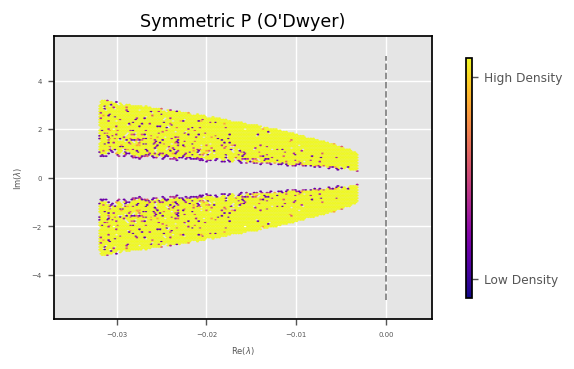

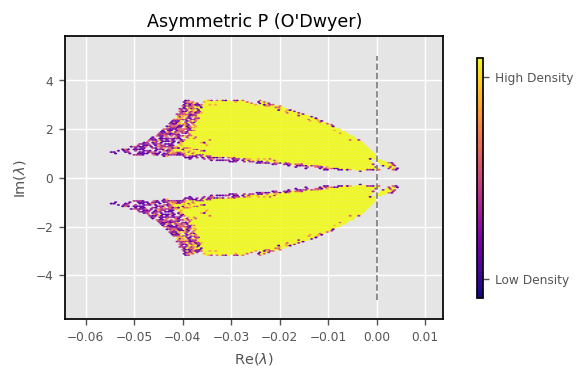

In [12]:
## Plot eigenvalues of linearized system ##

for i, q in enumerate([sev, aev]): # i index, q current value

    x = q.real
    y = q.imag

    plt.rcParams["axes.edgecolor"] = "black" 
    plt.rcParams["axes.linewidth"] = 1 
    
    fig, ax = plt.subplots(figsize = (5,3))

    #cmap = plt.cm.viridis_r  ### old, gets an error
    cmap = mpl.cm.get_cmap("plasma").copy()
    cmap.set_under(color = 'white', alpha = 0) 

    plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

    font = {'size' : 7}
    plt.rc('font', **font)

    plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

    plt.xlabel(r'Re($\lambda$)')
    plt.ylabel(r'Im($\lambda$)')

    plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
    ### originally, (10**(-8), 2.0)

    xmin, xmax = plt.xlim()
    nxm = (xmax - xmin) / 10 ### def'n some padding/margins
    plt.xlim((xmin - nxm, xmax + nxm))

    
    ### Adjusting Re axis tick marks
    if i==0: ### symmetric P
        loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
        ax.xaxis.set_major_locator(loc)
        plt.title('Symmetric P (O\'Dwyer)')
    if i==1: ### asymetric P
        loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
        ax.xaxis.set_major_locator(loc)
        plt.title('Asymmetric P (O\'Dwyer)')        

    ymin, ymax = plt.ylim()
    nym = (ymax - ymin) / 3
    plt.ylim((ymin - nym, ymax + nym))

    cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
    locs = cb.get_ticks()
    tl = locs[-1] * 2 / 25
    cb.set_ticks([tl, locs[-1] - tl])
    cb.set_ticklabels(['Low Density', 'High Density'])
        
plt.show();

## Old O'Dwyer Stuff

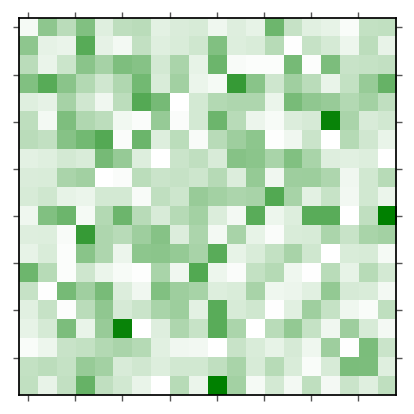

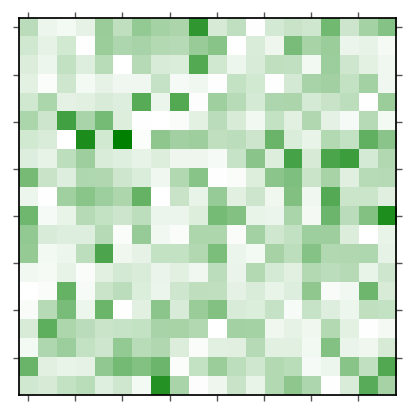

In [13]:
### Plot Grid Representing Production Matrix P ###

for i, M in enumerate([sP, aP]):
    
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'green'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                    cmap=c_map)

    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis = 'both',          
                    which = 'both',      
                    bottom = 'off',      
                    top = 'off',         
                    labelbottom = 'off',
                    left = 'off',
                    right = 'off')

    ax.grid(False)
plt.show();

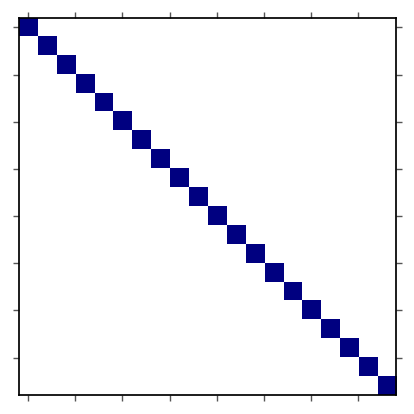

In [14]:
### Plot grid representing consumption C ###

C = c*I

for M in [C]:
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'navy'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                        cmap=c_map)


    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis='both',          
                    which='both',      
                    bottom='off',      
                    top='off',         
                    labelbottom='off',
                    left='off',
                    right='off')

    ax.grid(False)


## Frequency of stable n-size systems

In [15]:
### Original O'Dwyer method for determining/plotting stability
   # Do same as before but with k = 100 trials
    
k_test = 100
ns_test = list(range(1,61))
percents_stable_Odw = []

## Parameters ##
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

for nn in ns_test:
    
    aev = np.array([]) # just make new eigval array for each n, easier to just reshape after appending
                            # all eigvals for one system size (n) and append the stability_percent, then repeat
    I = np.identity(nn)

    ## Consumption Matrix ##
    C = c * I

    ## Production matrices ##
    sP = symP(sig, nn)
    aP = asymP(sig, nn)
    #sPvec = symPvec(sig, n)

    rlb = nn * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vector
                                                    #produces this equilibrium

    LD = np.zeros((nn, nn))

    for k in range(k_test): ### originally 5000
        ## Equilibrium Abundances ##
        r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
        s = uniform(rlb / 10**4, rlb / 1000)

        ## Linearized System ##
           ### Jacobian, L, eval'd at steady state
        #     [ LA | aLB]
        #aL = [---------]
        #     [ LC | LD ]
        LA  = -c * s * I

        aLB = aP - c * r * I

        LC = eps * c * s * I
        LD = np.zeros((nn, nn))

        aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))

        ## Eigenvalues of Linearized System ##

        aev = np.append(aev, eigvals(aL))
    
    aev = aev.reshape(k_test,2*nn)
    pos_real_cts = np.sum(aev>0,1)
    
    percents_stable_Odw.append(len(pos_real_cts[pos_real_cts==0])/k_test)
        

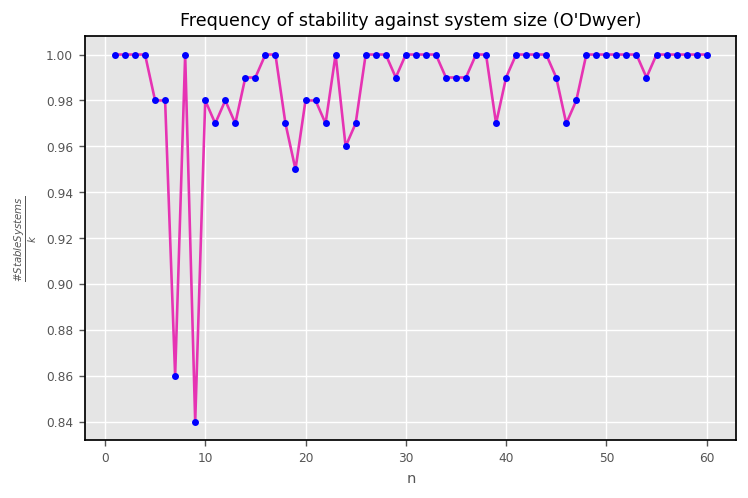

In [16]:
y_data = np.array(percents_stable_Odw)
x_data = np.array(ns_test)

plt.plot(x_data,y_data, color=(0.9,0.2,0.7));
plt.plot(x_data,y_data, 'b.');
plt.title('Frequency of stability against system size (O\'Dwyer)');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
plt.show();

# When using AN EVEN HIGHER SAMPLE SIZE (k=1000 vs. k=100 down below), still very chaotic-looking
    # but with dip near n=[8,12]. Hrm...
    # Also, very stable.

In [17]:
x_data[np.argmin(y_data)] # Least chance of having stable system at n=9

9

# 'Random P and Corresponding Equilibria' Approach

In [18]:
###############################################################################
# Instead, consider randomizing the (n,n) P(roduction matrix) and eval'ing its Jacobian only at 
    # the corresponding steady state.
# Choose k = 5000
# make (k,n,n) array (5000 P matrices)
# make (k,n,1) array (5000 R_stars)
# ""                 (5000 S_stars)
###############################################################################

## Setup for new approach

In [19]:
def extract_block_diags(A_,block_size):
    '''
    A, square matrix whose (square) block diagonals of shape (block_size,block_size) are to be extracted
    
    Previously needed for S_star_gen()

    '''
    block_diags = np.lib.stride_tricks.sliding_window_view(A_,(block_size,block_size))[::block_size,::block_size]
    num_blocks = int(A_.shape[0]/block_size)
    block_inds = list(range(num_blocks))
    
    return block_diags[block_inds,block_inds,:,:]

In [20]:
### According to Butler/O'Dwyer, for any CHOICE of (+) mu and rho, the formulae below will produce feasible Steady States

$\vec{R^*} = (C^T)^{-1}\frac{1}{\epsilon}(P^T \vec{1} + \vec{\mu})$)

In [204]:
# Why are r_i values as big as 100??? Any way to normalize/nondimensionalize the model?

def R_star_gen(C_,P_,eps_,mu_): # P_ is actually 3-dimensional matrix (k nxn sub-P-matrices)
    '''
    Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
    that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).
    
    No argument for number of sub-R_stars because that is inferred from 0th dimension of 'P_' argument.
    '''
    k_ = P_.shape[0]
    n_ = P_.shape[-1]
    # mu_ = np.tile(mu_,(k_,1,1))
    
    A_ = np.linalg.inv(C_.T)*(1/eps_) # A is just (k_,n_,n_)
    # print('P:',P.shape)
    # print('mu:',mu.shape)
    # print('k:',k_)
    # print('n:',n_)
    v_ = np.sum(np.transpose(P_,(0,2,1)), 2).reshape(k_,n_,1) + mu_.reshape(1,n_,1) #take row sums of P_ transpose, reshape to add 
    #v = np.sum(np.transpose(P_,(0,2,1)), 2).reshape(k_,n_,1) + mu_
    
    R_star_ = np.tensordot(A_,v_,axes=([1],[1]))
    R_star_ = R_star_.reshape(n_,k_).T.reshape(k_,n_,1)
    return R_star_

In [22]:
p = asymPvec(1,3,2)

p = np.random.randint(0,5,size=(2,3,3))

dink = np.ones(3)

dink.reshape(1,3,1)

p

np.sum(p,-1).reshape(2,3,1)

np.sum(p,-1).reshape(2,3,1) + dink.reshape(1,3,1)

array([[[1.],
        [1.],
        [1.]]])

array([[[3, 4, 3],
        [3, 0, 2],
        [4, 3, 3]],

       [[0, 2, 4],
        [0, 3, 1],
        [0, 4, 3]]])

array([[[10],
        [ 5],
        [10]],

       [[ 6],
        [ 4],
        [ 7]]])

array([[[11.],
        [ 6.],
        [11.]],

       [[ 7.],
        [ 5.],
        [ 8.]]])

In [23]:
# ### Resource-Competition Steady State vectors (R_star and S_star)
# # Why are Rstars in the range of r_i in [1,100]??? Any way to normalize/nondimensionalize the model?

# def R_star_gen(C,P,eps,mu): # P is actually 3-dimensional matrix (k nxn sub-P-matrices)
#     '''
#     Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
#     that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).
    
#     No argument for number of sub-R_stars because that is inferred from 0th dimension of P argument.
#     '''
    
#     k = P.shape[0]
#     n = P.shape[-1]
#     mu = np.tile(mu,(k,1,1))
    
#     #C = np.tile(C,(k,1,1)) # OLD: stack C k times so that it can be dotted with each sub-Ps
#                                 # np.dot() does not broadcast, I think. Have to manually add 3rd dimension
#     #A = np.linalg.inv(np.transpose(C,(0,2,1)))*(1/eps) # split up into A,v for readability
#     A = np.linalg.inv(C.T)*(1/eps) # A is just (k,n,n)
#     v = np.sum(np.transpose(P,(0,2,1)), 2).reshape(k,n,1) + mu #take row sums of P transpose, reshape to add 
    
#     # How to pairwise dot an array of 2D matrices with array of column vectors?
    
#     R_star = np.tensordot(A,v,axes=([1],[1]))
#     R_star = R_star.reshape(n,k).T.reshape(k,n,1)
#     #np.tensordot(I,b,axes=([1],[1])).reshape(2,3).T.reshape(3,2,1)
#     return R_star

$\vec{S^*} = [(R^{*}_{diag})C - P]^{-1} \vec{\rho}$


In [154]:
def S_star_gen(C_,P_,R_star_,rho_):
    k_ = P_.shape[0]
    n_ = P_.shape[1]
    
    R_diag_ = np.zeros((k_,n_,n_))
    d_inds_ = np.diag_indices(n_)
    R_diag_[:,d_inds_[0],d_inds_[1]] = R_star_.reshape(k_,n_)
        
    RC = np.dot(R_diag_, C_)

    A_ = np.linalg.inv(RC - P_) # "Subtract across" RC and P
    
    # This time, we have many different sub-A right-multiplied by constant vector rho
    S_star_ = np.dot(A_, rho_)
    
    return S_star_.reshape(k_,n_,1)

In [25]:
# def S_star_gen(C,P,R_star,rho):
#     k = P.shape[0]
#     n = P.shape[1]

#     R_diag = np.zeros((k*n,k*n))
#     np.fill_diagonal(R_diag, R_star.reshape(k*n,))
#     # now, R_diag is big array
#     R_diag = extract_block_diags(R_diag, n) # get each R_diag in (k,n,n)-shaped array
    
#     ### FIX THIS LATER FOR NON-IDENTITY C ################################
#     #  RC = np.dot(R_diag, C) # real way would be sth like this
#     RC = R_diag
    
#     A = np.linalg.inv(RC - P) # pairwise subtract RC and P
#     #S_star = np.dot(A, rho)  # in a perfect world, this is the answer
    
#     # this time, we have many different sub-A and constant rho
#     S_star = np.tensordot(A,rho.reshape(1,n,1),axes=([2],[1])) #.reshape(n,k).T.reshape(k,n,1) # we do not live in a perfect world

#     return S_star.reshape(k,n,1)

## Testing eigvals of new vectorized system

In [26]:
### Now, can generate k many P matrices, together with shape (k,n,n), and the corresponding R_stars and S_stars for Jacobian at equilibrium

sEVs = np.array([])
aEVs = np.array([])

## Parameters ##
n   = 20      # number of species AND number of resrcs --> Jacobians will be (2*n,2*n)
k = 750       # number of systems to generate
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1      # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
rho = (np.ones(n)*0.5).reshape(n,1)


### SEE METHODS in O'Dwyer FOR mu AND rho formulae if needed
I = np.identity(n)

## Consumption Matrix ##
C = c * I

### Generating Random P-matrices, fixing mu and rho, and eval'ing Jacobian at corresponding equilibria
    ### Then, find dominant eigenvalues.
    ### Each system will contribute 2*n eigenvalues, so we can reshape eigval list to later determine how many systems had a stable equilibrium

## Production matrices ##
sP = symPvec2(sig, n, k)
aP = asymPvec(sig, n, k)

## Equilibrium Abundances ##
sR_star = R_star_gen(C,sP, eps, mu)
sS_star = S_star_gen(C,sP, sR_star, rho)

aR_star = R_star_gen(C,aP, eps, mu)
aS_star = S_star_gen(C,aP, aR_star, rho)


## Linearized System ##
   ### Jacobian, L, eval'd at steady state
#     [ LA | LB ]
#aL = [---------]
#     [ LC | LD ]

# Community Matrix for Symmetric P
sLA  = -c * sS_star * I
sLB = sP - c * sR_star * I
sLC = eps * c * sS_star * I

# Community Matrix for Asymmetric P
aLA = -c * aS_star * I
aLB = aP - c * aR_star * I
aLC = eps * c * aS_star * I

LD = np.zeros((k, n, n)) # same for both cases P


sL  = np.concatenate((np.concatenate((sLA, sLB),2), np.concatenate((sLC, LD),2)), 1)
# aL  = np.vstack((np.hstack((aLA, aLB)), np.hstack((aLC, LD))))
aL  = np.concatenate((np.concatenate((aLA, aLB),2), np.concatenate((aLC, LD),2)), 1)


## Eigenvalues of Linearized System ##

sEVs = np.append(sEVs, eigvals(sL))
aEVs = np.append(aEVs, eigvals(aL))

In [27]:
# eigvals(sL).shape
# sEVs.shape

## What is going on with the tendency for eigvals ~=~ 0.4???

## Function for eigvals of our random systems

In [28]:
def eigval_gen(P,eps,mu,rho): # For now, just identity C, ADD AS ARGUMENT LATER
    '''
    Gets eigvals of system given P and parameters.
    
    Needs to be updated to take C as argument. For now, just uses identity matrix for C (perfect specialists).
    Also, mu, rho, and epsilon.
    '''
    EVs = np.array([])

    ## Parameters ##
    n = P.shape[-1]
    k = P.shape[0]

    ## Consumption Matrix ##
    c = 1.0 # Keeps cool curve from 0-1, chaotic-looking when > 1
    I = np.identity(n)
    C = c * I
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LD = np.zeros((k, n, n))

    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)

    # Community Matrix Partitions
    LA  = -c * S_star * I
    LB = P - c * R_star * I
    LC = eps * c * S_star * I

    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)

    return eigvals(L)

In [29]:
# Old rand_eigval_gen() is minimized below this cell.
# New eigval_gen() above just requires that you make your own P-matrices now.
    # That way, you can keep track of the P-matrices that led to the eigvals that you get.

In [30]:
#### OLD ####
def rand_eigval_gen(n, k, sig = 1, symmetric=True): # For now, just identity C, ADD AS ARGUMENT LATER
    '''
    Takes same arguments as (a)symPvec(), but performs all of the eigenvalue calcs for each of the k matrices
    
    Needs to be updated to take C as argument. For now, just uses identity matrix for C (perfect specialists).
    Also, mu, rho, and epsilon.
    '''
    
    EVs = np.array([])

    ## Parameters ##

    # n   = 20      # number of species AND number of resrcs
    # k = 750        # number of systems to generate
    eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
    # sig = 25      # std deviation of production rates? Yes, also for abundances?
    c = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
    #mu = np.random.unif(0,1,n) 
    mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
    #rho = np.random.unif(0,1,n)
    rho = (np.ones(n)*0.5).reshape(n,1)
    ### SEE METHODS FOR mu AND rho


    ## Consumption Matrix ##
    I = np.identity(n)
    C = c * I
    # C = np.identity(n)

    
    # only difference between symmetric=True and otherwise is the call to symPvec2() or asymPvec()
        
    ## Choice of Production matrices ##
    if (symmetric):
        P = symPvec2(sig, n, k)
    else:
        P = asymPvec(sig, n, k)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LD = np.zeros((k, n, n))


    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)

    # Community Matrix Partitions
    LA  = -c * S_star * I
    LB = P - c * R_star * I
    LC = eps * c * S_star * I


    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)


    # EVs = np.append(EVs, eigvals(L)) # old
    # print(P)
    return eigvals(L)

## Frequency of stable n-size systems

In [31]:
# Small systems (small n) almost always stable

ns_test = list(range(2,41))
percents_stable = []

k_test=100
eps = 0.25

for nn in ns_test:
    n_test = nn
    # ev_ex = rand_eigval_gen(n_test,k_test,sig = 1, symmetric=False)
    
    P_ex = asymPvec(sig = 1, n = n_test, k=k_test)
    mu_ex = (np.ones(n_test)*0.5).reshape(n_test,1)
    rho_ex = (np.ones(n_test)*0.5).reshape(n_test,1)

    ev_ex = eigval_gen(P_ex, eps, mu_ex, rho_ex)
    
    reals = ev_ex.real
    
    pos_real_cts = np.sum(reals>0,-1)
    percents_stable.append(len(pos_real_cts[pos_real_cts==0])/k_test) # ratio of stable systems to total systems (k)


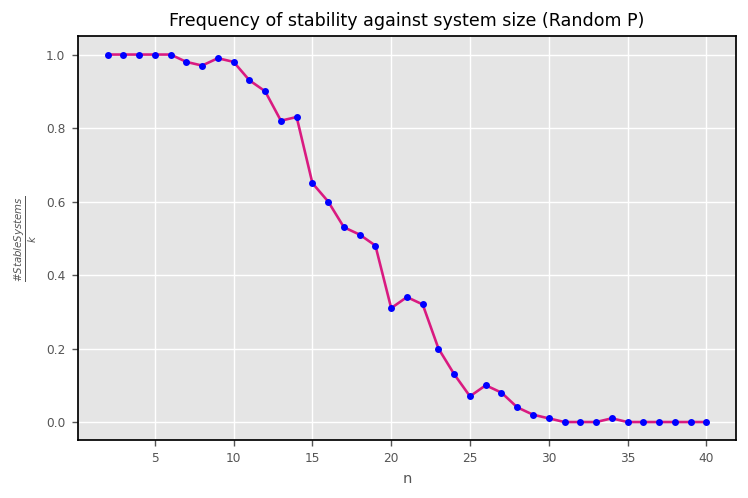

In [32]:
xdata = np.array(ns_test)
ydata = np.array(percents_stable)

# I forgot how to suppress matplotlib output automatically
plt.plot(xdata,ydata, color=(0.85,0.1,0.5));
plt.plot(xdata,ydata, 'b.');

plt.title('Frequency of stability against system size (Random P)');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
plt.show();
# Fit with Negative binomial ?

The above data have a form similar to
$$ f(x) = a\frac{e^{r(x-d)}}{c+e^{r(x-d)}}, $$
with reals $r<0,$ and $a,c,d>0$.

### Fitting the peculiar curve

In [33]:
from scipy.optimize import curve_fit

In [34]:
def logistic(x, a, r, c, d): # Model Guess 1: Logistic Decay
    y = a * (np.e**(r*(x-d)) / (c + np.e**(r*(x-d))))
    return y

# Model Guess 2: Negative Binomial (Failure Probability)

In [35]:
guess = [1, -0.1, 0.9, 20] # guess from playing with desmos sliders
parameters, covariance = curve_fit(logistic, xdata, ydata, p0 = guess) # least-squares default?
fit_a = parameters[0]
fit_r = parameters[1]
fit_c = parameters[2]
fit_d = parameters[3]
print(fit_a)
print(fit_r)
print(fit_c)
print(fit_d)

1.0306520020488892
-0.2910446314207508
0.7988405239532274
17.08813772221264


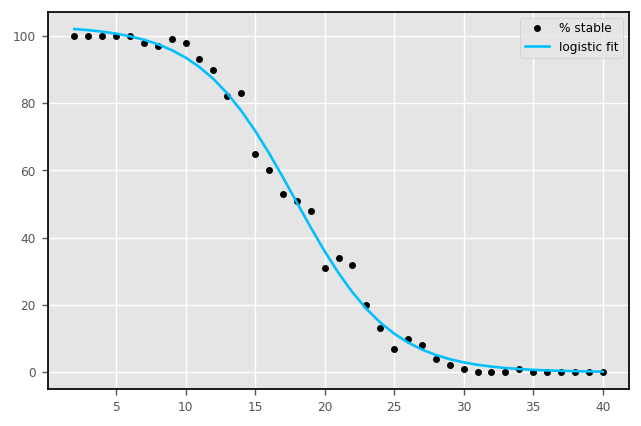

In [36]:
fit_logistic_y = logistic(xdata, fit_a, fit_r, fit_c, fit_d)
plt.plot(xdata, 100*ydata, 'k.', label='% stable');
plt.plot(xdata, 100*fit_logistic_y, 'deepskyblue', label='logistic fit');
plt.legend();

## Back to plotting eigvals

In [325]:
np.any(aEVs > 0)

True

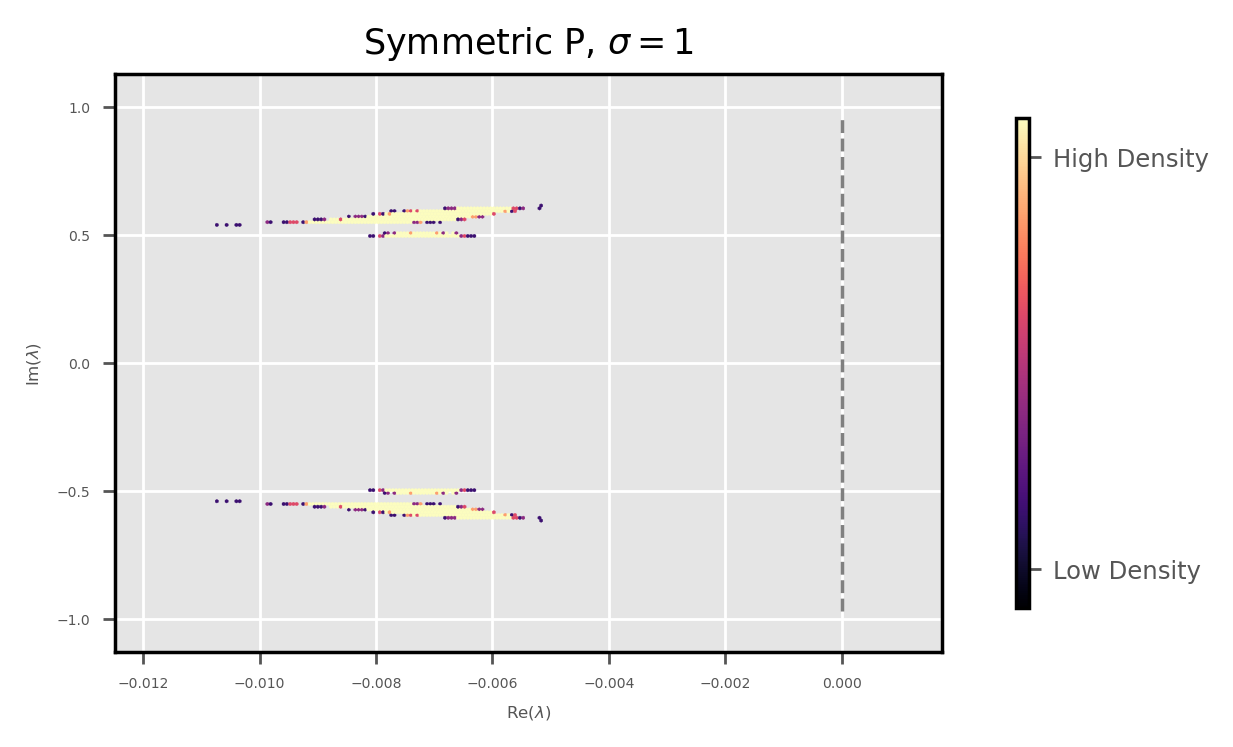

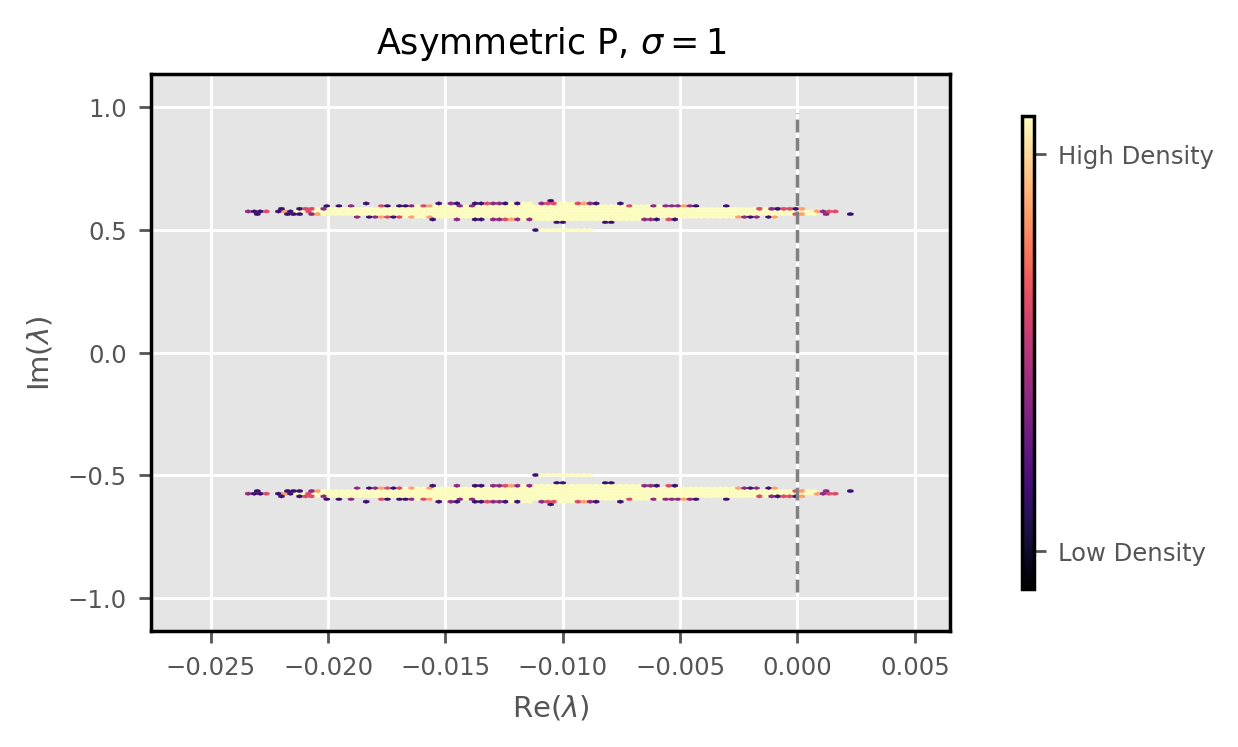

In [323]:
### Plot Eigenvalues of Various Linearized Systems
    ### (Eval'd at the respective steady states for single fixed mu and rho
    
# Loop the code below over a list of sigmas
    # Subplots with left column symmetric, right asymmetric
    # Make list, stability_probs. For each aEVs with different sig, append the
      # ratio of matrices that have any Re(eigval)>0 to k.

#sigs = [0.5,1,2,5,10]
sigs = [1]
# just have one pair (sEVs,aEVs) at a time for simplicity
    # generate sEVs, aEVs with current sigma
    # plot them
    # append to stability_freq using aEVs

n = 20      # number of species AND number of resrcs
k = 1000     # number of systems to generate

sP = symPvec(sig=1, n=n, k=k)
aP = asymPvec(sig=1, n=n, k=k)

mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)

stability_freqs = [] # len(sigs)

for j, s in enumerate(sigs): # Plotting was being buggy, no longer looping over multiple sigmas
    sEVs = eigval_gen(sP, eps, mu, rho)
    aEVs = eigval_gen(aP, eps, mu, rho)
    for i, q in enumerate([sEVs, aEVs]): # i index, q current value

        x = q.real
        y = q.imag
        
        plt.rcParams["axes.edgecolor"] = "black" 
        plt.rcParams["axes.linewidth"] = 1 

        fig, ax = plt.subplots(figsize = (5,3))

        cmap = mpl.cm.get_cmap("magma").copy()
        cmap.set_under(color = 'white', alpha=0) 

        plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

        font = {'size' : 7}
        plt.rc('font', **font)

        # plt.subplot(len(sigs),2,(j+i+1));
        plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

        plt.xlabel(r'Re($\lambda$)')
        plt.ylabel(r'Im($\lambda$)')

        plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
        ### originally, (10**(-8), 2.0)

        xmin, xmax = plt.xlim()
        nxm = (xmax - xmin) / 10 ### def'n some padding/margins
        plt.xlim((xmin - nxm, xmax + nxm))

        ### Adjusting Re axis tick marks
        if i==0: ### symmetric P
            loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
            # ax.xaxis.set_major_locator(loc)
            plt.title(r'Symmetric P, $\sigma={}$'.format(s))

        if i==1: ### asymmetric P
            loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
            # ax.xaxis.set_major_locator(loc)
            plt.title(r'Asymmetric P, $\sigma={}$'.format(s))
            
        cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
        locs = cb.get_ticks()
        tl = locs[-1] * 2 / 25
        cb.set_ticks([tl, locs[-1] - tl])
        cb.set_ticklabels(['Low Density', 'High Density'])

        ymin, ymax = plt.ylim()
        nym = (ymax - ymin) / 3
        plt.ylim((ymin - nym, ymax + nym))
        
        plt.tight_layout()

plt.show();

# Arnoldi Measures

## Misc.

In [38]:
def community_matr_gen(C_,P_,eps_,mu_,rho_):
    '''
    Returns L, the community matrix (Jacobian) of an O'Dwyer system described by given:
        Consumption matrix C,
        Production matrix P, 
        Exogenous mu,
        rho
    '''
    n = P_.shape[-1]
    k = P_.shape[0]
    I = np.identity(n)
        
    LD = np.zeros((k, n, n))

    ## Equilibrium Abundances ##
    R_star = R_star_gen(C_, P_, eps_, mu_)
    S_star = S_star_gen(C_, P_, R_star, rho_)
    
    # Community Matrix Partitions
    CS = np.dot(C_, S_star).T.reshape(k,n,1) # can use regular .T because first dimension is 1
    CR = np.dot(C_, R_star).T.reshape(k,n,1)
    
    LA  = -CS * I
    LB = P_ - CR * I
    LC = eps_ * CS * I

    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)
    
    return L

In [39]:
def dom_eigvals(A): # for A shape (k,2*n,2*n) ; returns entire eigval (complex, with sign)
    if A.ndim == 2:
        A = A.reshape(1,A.shape[0],A.shape[1])    
    k = A.shape[0]
    
    evs = eigvals(A)
    
    dom_ev_ind = (np.argmax(evs.real,-1)) 
    dom_ev = evs[np.arange(0,k), dom_ev_ind]
    
    return dom_ev

In [40]:
def dom_eigval_single(A): # Just for spectral_norm()
    evs = eigvals(A)
    
    dom_ev_ind = (np.argmax(evs.real,-1)) 
    dom_ev = evs[dom_ev_ind]
    
    return dom_ev

## "Resilience, reactivity and variability..." (2016)

In [238]:
np.random.seed(667)
n = 2
k = 1000
mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)
eps = 0.25
C = np.identity(n)
# C = abs(np.random.randn(n,n)) # literally never stable, equilibria are ruined
P = symPvec(sig = 1, n = n, k = k)
# P = asymPvec(sig = 1, n = n, k = k)

J = community_matr_gen(C,P,eps,mu,rho)
J.shape

(1000, 4, 4)

In [239]:
# Equilibria
R_star = R_star_gen(C,P,eps,mu)
S_star = S_star_gen(C,P,R_star,rho)

# R_star[0,:,:]
# S_star[0,:,:]

### Pre-Arnoldi sanity check

### The 4 measures

In [240]:
# 'A' will mean a (k,2*n,2*n) stack of community matrices (Jacobian evaluated at R_star,S_star)
# Suffix _mb to denote measures computed from O'Dwyer MicroBiome model

#### Asymptotic Resilience

In [241]:
def asym_res(A):
    if A.ndim == 2:
        A = A.reshape(1,A.shape[0],A.shape[1])
    k = A.shape[0]
    dom_ev = dom_eigvals(A)
    
    R_inf = -dom_ev.real
    
    return R_inf

In [242]:
R_inf_mb = asym_res(J)

#### Deterministic Invariability
$$\mathcal{I}_D = \frac{1}{\sup_{\omega}||(i\omega - A)^{-1}||}$$

In [243]:
# i*omega - A is shorthand for I_n * i*omega - A

In [244]:
from scipy.optimize import minimize
from scipy.optimize import brent
from scipy.optimize import minimize_scalar # which Brent?

In [245]:
def spectral_norm(A): # only takes 1 matrix
    dom_ev = dom_eigval_single(np.dot((A.T).conjugate(), A))

    return np.emath.sqrt((dom_ev.real)) # np.emath.sqrt returns complex if takes negative # Take the real part?

In [246]:
# Find omega that maximizes ||inverse(i*om-A)||_{spectral}
# Objective function:
def determ_invar_OBJ(om, A):
    B = np.linalg.inv(np.eye(A.shape[-1])*complex(0,om) - A)  # call B the matrix whose spectral norm we aim to maximize    
    return -spectral_norm(B) # negative because we are maximizing

In [247]:
# Deterministic Invariability
def determ_invar(om, A): # assumes you have found argmin omega    
    B = np.linalg.inv(np.eye(A.shape[-1])*complex(0,om) - A)
    
    return 1 / spectral_norm(B)

In [248]:
# Loop through each Community matrix to get their I_D
I_D_mb = []
oms = []
I_D_mb_alt = [] # using scipy.optimize.brent() instead of minimize_scalar()
oms_alt = []
for i in range(k):
    
    out = minimize_scalar(determ_invar_OBJ, args=(J[i,:,:]), method='brent')
    out_alt = minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(J[i,:,:]), method='brent')

    oms.append(out.x)
    I_D_mb.append(-1/out.fun) # out.fun is still negative bc of obj function minimizing the opposite to find maximum
    oms_alt.append(out_alt.x)
    I_D_mb_alt.append(-1/out_alt.fun)

I_D_mb = np.array(I_D_mb)
I_D_mb_alt = np.array(I_D_mb_alt)

#### Stochastic Invariability

$$\mathcal{I}_S = \frac{1}{2} ||-\hat{A}^{-1}||^{-1}$$
$$ \hat{A} = A \otimes I + I \otimes A $$

In [249]:
def stoch_invar(A):
    # NOT vectorized bc Kronecker product (at the moment)
    I = np.identity(A.shape[-1])
    A_hat = np.kron(A,I) + np.kron(I,A)
    
    temp = -np.linalg.inv(A_hat)
    spec_norm = spectral_norm(temp)
    
    SI = 0.5 / spec_norm
    
    return SI

In [250]:
I_S_mb = []
for i in range(k):
    I_S_mb.append(stoch_invar(J[i,:,:]))

len(I_S_mb)

I_S_mb = np.array(I_S_mb)

1000

#### Initial Resilience

In [251]:
def init_res(A):
    
    if A.ndim == 2:  # to account for when passing a single community matrix A, shape (2*n,2*n)
        A = A.reshape(1,A.shape[0],A.shape[1])
    k = A.shape[0]
    
    temp = A + np.transpose(A, (0,2,1)) # symmetric matrices have real eigvals
    
    dom_evs = dom_eigvals(temp)
    
    R0 = -0.5* dom_evs
    
    return R0

In [252]:
R_0_mb = init_res(J)
R_0_mb.shape

(1000,)

In [253]:
# These systems have nearly guaranteed stability for small n (less than 6 or so)

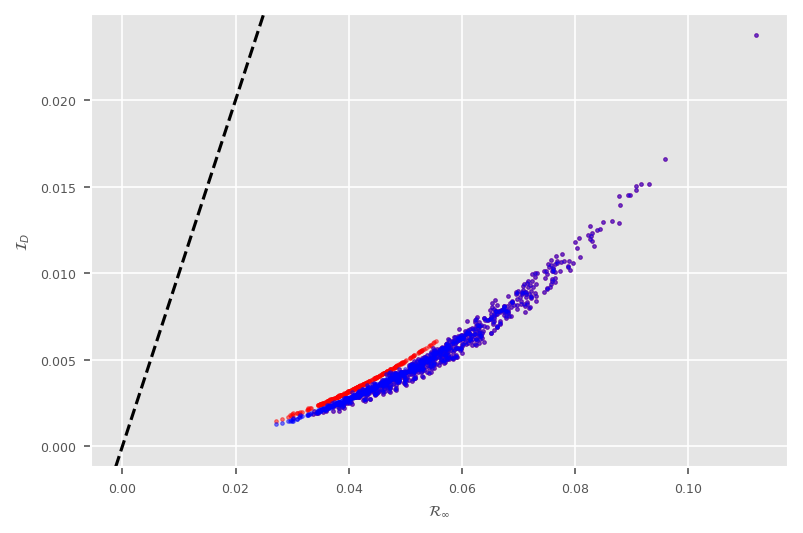

In [257]:
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams.update({'font.size': 6})
plt.scatter(x=R_inf_mb,y=I_D_mb, s=3, c='r', alpha = 0.5);
plt.scatter(x=R_inf_mb,y=I_D_mb_alt, s=3, c='b', alpha = 0.5); # Different optimization parameters, makes I_D smaller as desired
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_D$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

### Arnoldi plots of O'Dwyer Systems

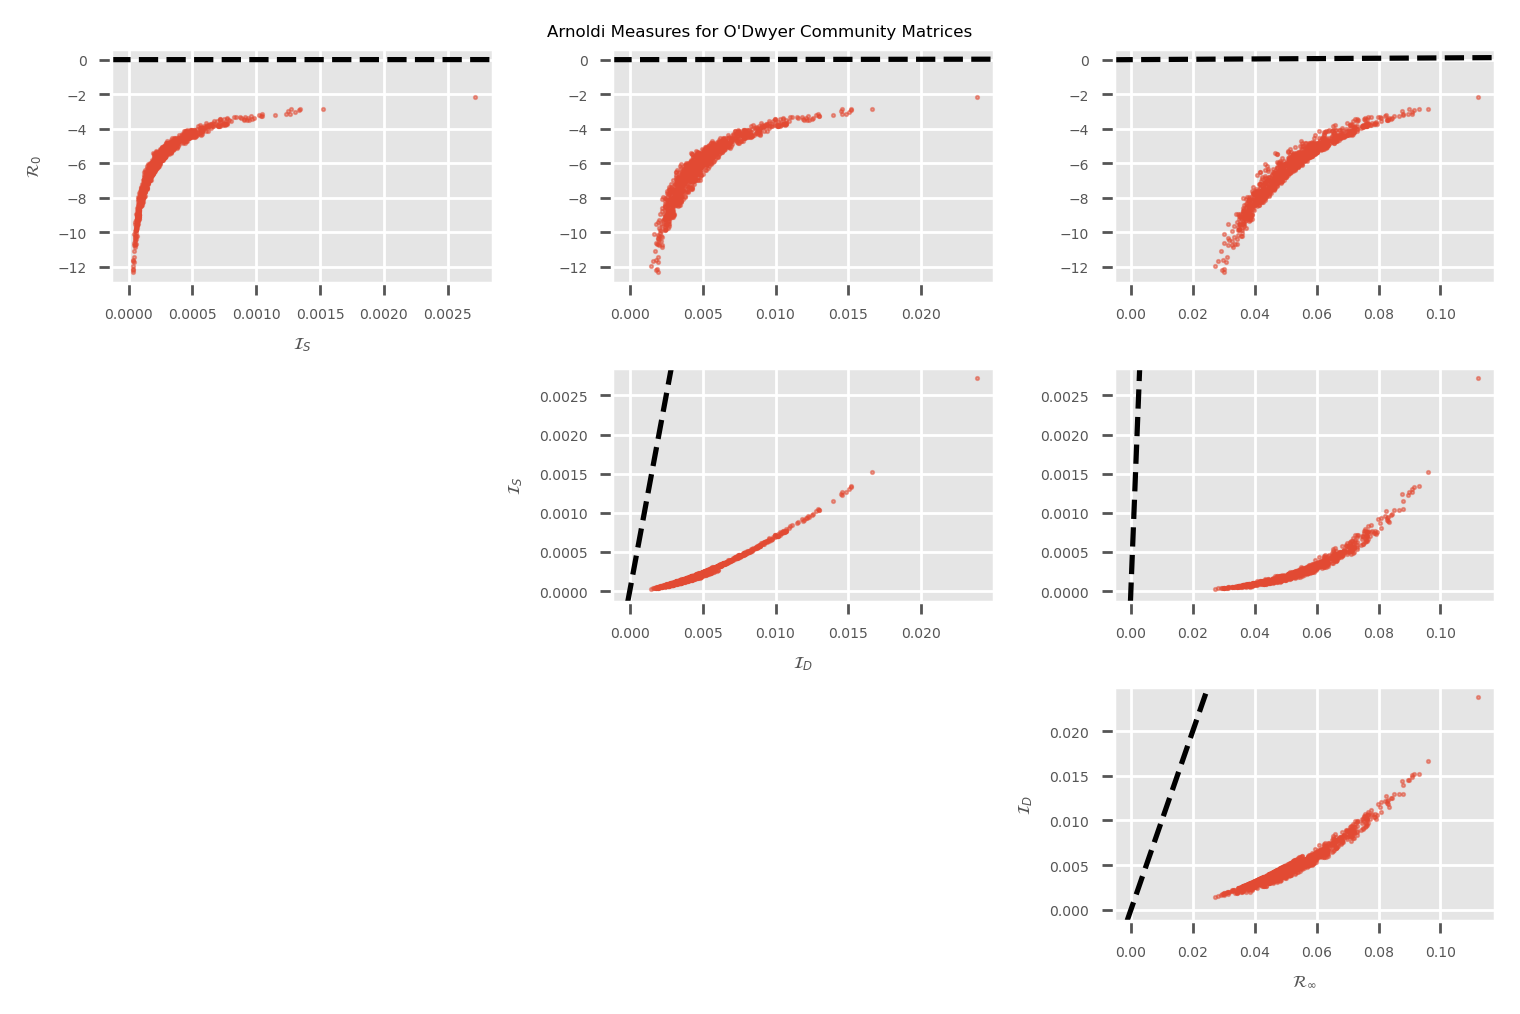

In [262]:
mpl.rcParams['figure.dpi'] = 250
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 4})


plt.subplot(3,3,1)
plt.scatter(x=I_S_mb,y=R_0_mb, s = 1,alpha = 0.5);
# plt.xticks(fontsize=3);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,2)
plt.scatter(x=I_D_mb,y=R_0_mb, s=1, alpha = 0.5);
# plt.xlabel(r'$\mathcal{I}_D$');
# plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,3)
plt.scatter(x=R_inf_mb,y=R_0_mb, s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,5)
plt.scatter(x=I_D_mb,y=I_S_mb, s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{I}_D$');
plt.ylabel(r'$\mathcal{I}_S$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,6)
plt.scatter(x=R_inf_mb,y=I_S_mb, s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,9)
plt.scatter(x=R_inf_mb,y=I_D_mb, s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_D$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.suptitle('Arnoldi Measures for O\'Dwyer Community Matrices');

plt.tight_layout();

## Copying Arnoldi Plots 

In [59]:
### Copy Arnoldi for sanity check

# np.random.seed(1)
np.random.seed(667)
S = 3
k = 1000
A = np.random.randn(k,S,S)
d = np.random.uniform(-1,0, (k,S))
d_ind = np.diag_indices(S)
A[:, d_ind[0],d_ind[1]] = d
A[0:2,:,:]

array([[[-0.0339146, -0.0628305, -2.2412373],
        [ 0.4838451, -0.4941459,  0.9215031],
        [ 0.2790376, -2.1191639, -0.0529728]],

       [[-0.2506633,  0.4582808,  0.7569159],
        [ 0.5215322, -0.8091574,  0.3345563],
        [ 0.6402031,  1.4538909, -0.7602865]]])

In [60]:
# Get only the stable systems
A_evs = eigvals(A)
A_reals = A_evs.real
neg_real_cts = np.sum(A_reals<0,-1)
stable_inds = np.where(neg_real_cts == S)[0] # S = 3 here, matrix dimension
stable_inds.shape # Scatterplots with have this many points
unstable_inds = np.where(neg_real_cts != S)[0]

(385,)

In [61]:
tempR0 = init_res(A[stable_inds,:,:])

In [62]:
tempRinf = asym_res(A[stable_inds,:,:])

In [63]:
tempI_S = []
for i in stable_inds:
    tempI_S.append(stoch_invar(A[i,:,:]))

tempI_S = np.array(tempI_S)

In [64]:
tempI_D = [] # for brent without bracket
temp_oms = []
tempI_D2 = [] # for brent optimization with bracket; overall better, it seems
temp_oms2 = []
for i in stable_inds:
    out = minimize_scalar(determ_invar_OBJ, args=(A[i,:,:]), method='brent')
    out2 = minimize_scalar(determ_invar_OBJ, bracket=(0,2.25), args=(A[i,:,:]), method='brent', options={'maxiter':1000})
    temp_oms.append(out.x)
    tempI_D.append(-1/out.fun)
    tempI_D2.append(-1/out2.fun)
    temp_oms2.append(out2.x)

tempI_D = np.array(tempI_D)
tempI_D2 = np.array(tempI_D2)
temp_oms = np.array(temp_oms)
temp_oms2 = np.array(temp_oms2)

In [65]:
problem_inds = np.where(tempI_D2>tempRinf)[0] # where does tempI_D break the rules
problem_inds

array([322], dtype=int64)

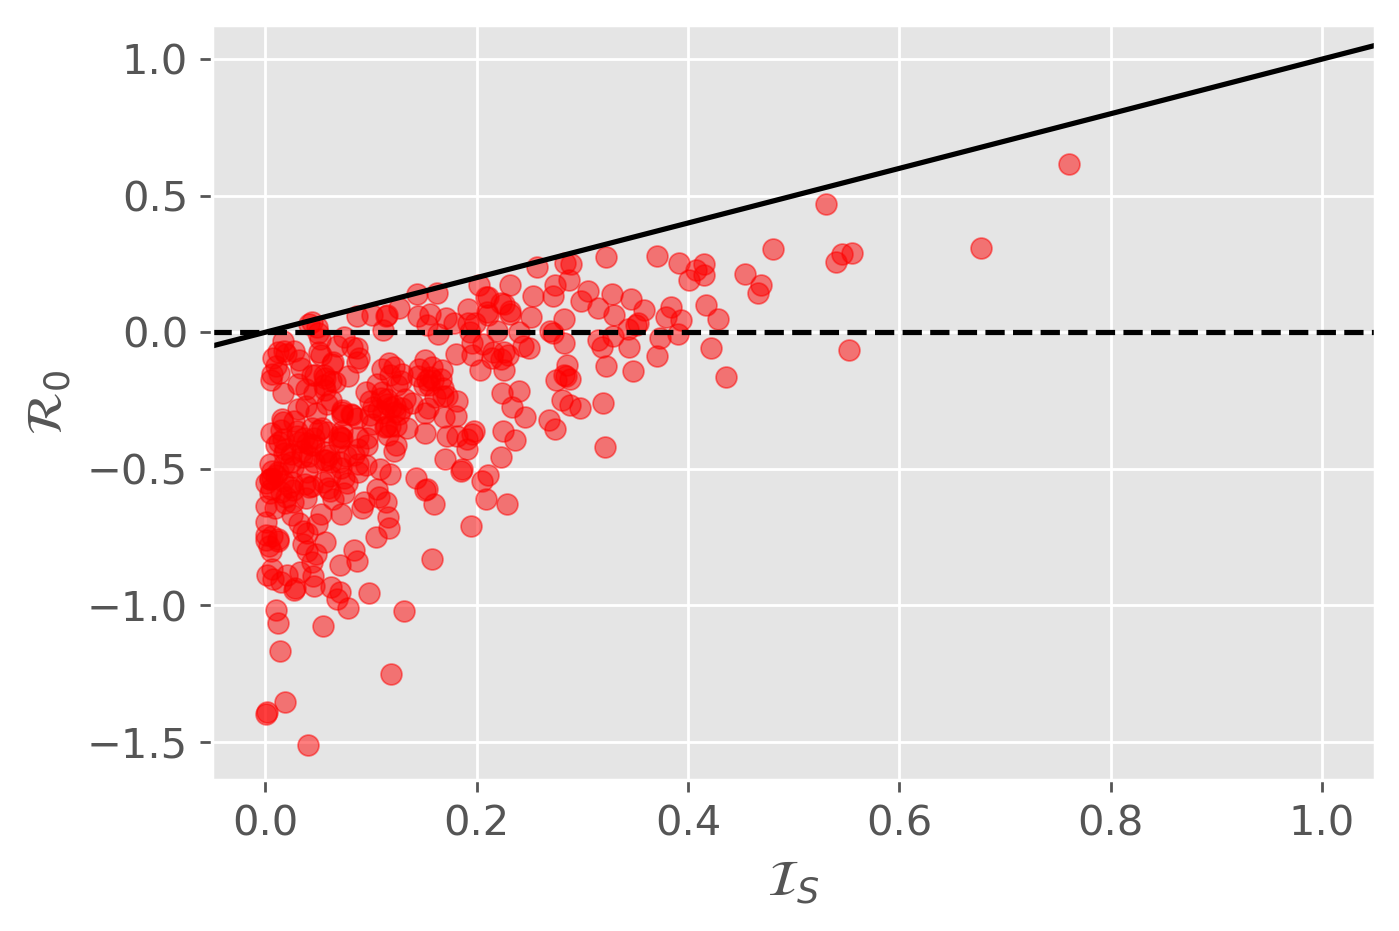

In [66]:
# plt.figure(figsize=(3,3), dpi=100)
mpl.rcParams.update({'font.size': 12})

plt.scatter(tempI_S, tempR0, color='r', alpha=0.5);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),xy2=(1,1), color='k');
plt.axhline(y=0,color='k',linestyle='--');
# plt.scatter(tempI_S[140], tempR0[140], color='b', alpha=1);

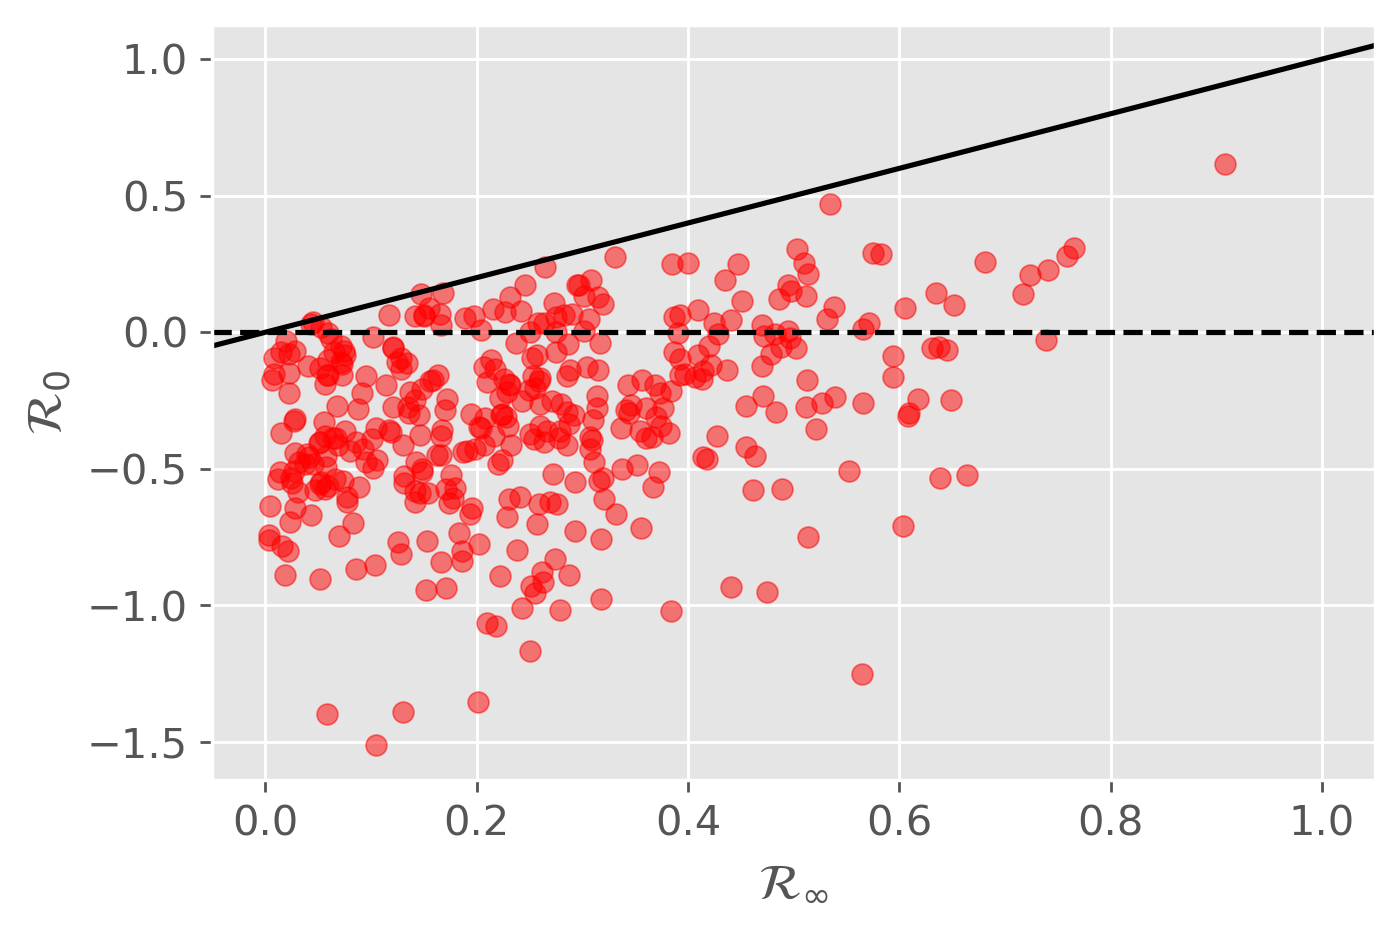

In [67]:
# plt.figure(figsize=(3,3), dpi=100)
plt.scatter(x=tempRinf, y=tempR0, color='red', alpha = 0.5);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{R}_{0}$');

plt.axline(xy1=(0,0), xy2=(1,1), color = 'k');
plt.axhline(y=0,color='k',linestyle='--');
plt.show();

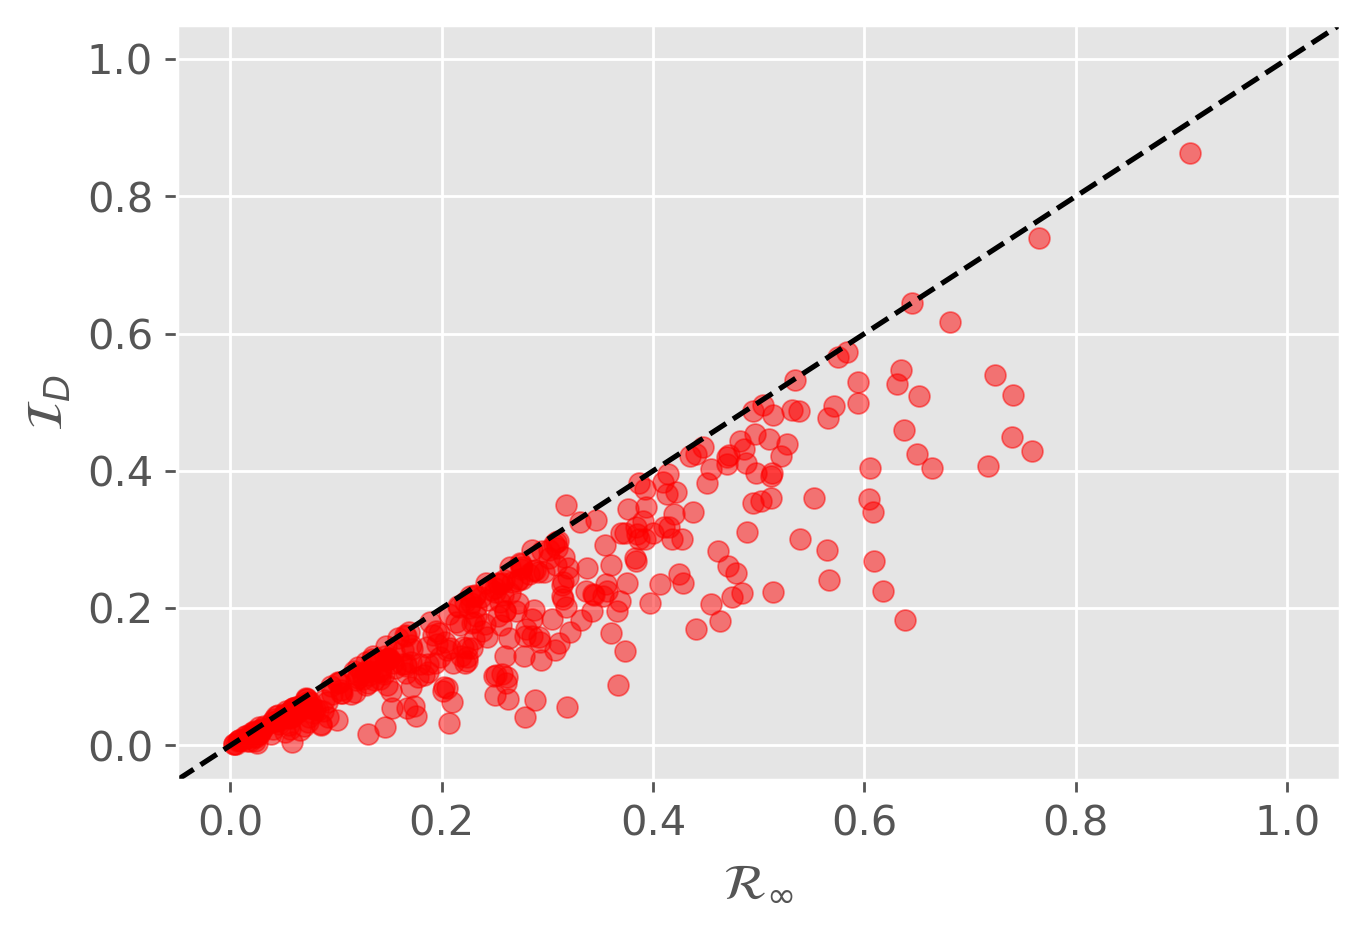

In [68]:
# plt.figure(figsize=(3,3),dpi=100)
# plt.scatter(x=tempRinf[problem_inds], y=tempI_D[problem_inds], color='k', alpha=1);
# plt.scatter(x=tempRinf, y=tempI_D, color='r', alpha=0.5);
plt.scatter(x=tempRinf, y=tempI_D2, color='r', alpha=0.5);

plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_{D}$');
plt.axline(xy1=(0,0), xy2=(1,1), color = 'k', linestyle ='--');
plt.show();

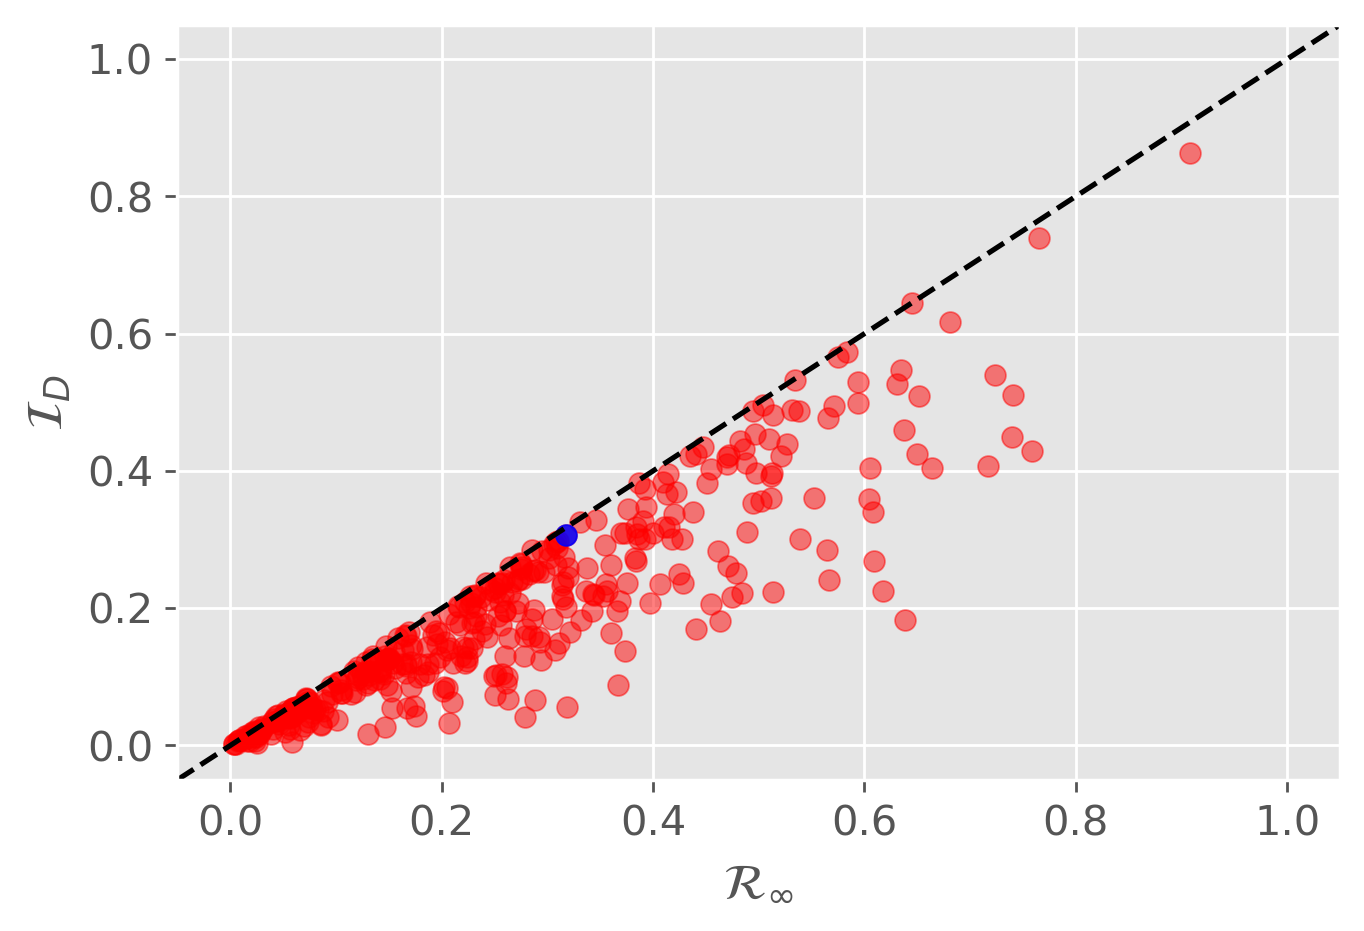

In [69]:
# For any problematic points in Deterministic Invariability, re-optimize but with a method that takes an initial guess
tempI_D_fixed = tempI_D2.copy()

guess = 2
for i in problem_inds:
    tempI_D_fixed[i] = minimize(determ_invar, x0=guess, args=(A[stable_inds[i]]), method='Nelder-Mead').fun

tempI_D2[problem_inds[0]]
tempI_D_fixed[problem_inds[0]]

# plt.figure(figsize=(3,3),dpi=100)
plt.scatter(x=tempRinf, y=tempI_D_fixed, color='r', alpha=0.5);
plt.scatter(x=tempRinf[problem_inds], y=tempI_D_fixed[problem_inds], color='b', alpha=0.85);
# Corrected points in blue
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_{D}$');
plt.axline(xy1=(0,0), xy2=(1,1), color = 'k', linestyle ='--');
plt.show();

## Distribution of community matrix entries

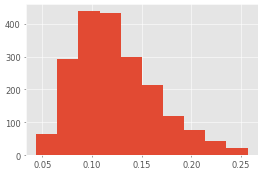

In [70]:
mpl.rcParams['figure.dpi'] = 50
plt.hist(S_star.reshape(-1));

In [71]:
R_star[0,:,:]

array([[18.6339036],
       [ 6.1867023]])

In [72]:
S_star[0,:,:]

array([[0.0588075],
       [0.1984622]])

## "How ecosystems recover ..." (2018) [CAN SKIP]

"We showed that in large, complex communities, due to the presence
of species with very different abundances, asymptotic resilience need not even be a good predictor 
of return rates at longer times."

"[...] asymptotic resilience should not be used as a proxy for the short-term recovery."

(pg. 8 "How ecosystems recover[...]")

In [73]:
### Arnoldi  "How ecosystems recover..."
n = 20 #repeated
import scipy as sp # for matrix exponential
from scipy.linalg import expm

In [74]:
# Return Rates
def R_avg(x, t, u):
    '''
    Average rate of return at current displacement 'x' after time 't' since initial perturbation 'u'
    '''
    return -( np.log(np.linalg.norm(x,2)) - np.log(np.linalg.norm(u,2))) / t

In [75]:
# Arnoldi Appendix E suggests def'n v with v_i std Gaussian, then normalize to u. Why Gaussian?? 
def u_gen_unif(n):
    '''
    Generate uniformly distributed unit-length  perturbation vector u.
    
    The direction is ostensibly the uniformly distributed value.
    '''
    v = np.random.normal(0,1,n) # so-called 'v' in Arnoldi
    return v/np.linalg.norm(u,2) # does this provide uniformly distributed perturbation direction? They say so.

In [76]:
# Really, according to Arnoldi, perturbations should tend to have greater effect on more abundant species.
# This is pretty subjective, I suppose? Is there empirical justification for this 'tendency'?

In [77]:
# Perturbation covariance matrix, Cov, for uniform perturbation direction
Cov_unif = np.identity(n)/n # for when equilibrium populations not being considered in perturbation distribution

In [78]:
# Choose an example system for testing Arnoldi measures
n_arn = 5
k_arn = 2
sig_arn = 1
eps = 0.25
c = 1
I = np.identity(n_arn)*c
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn)

In [79]:
R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
R_arn
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
S_arn

array([[[24.3266659],
        [17.468694 ],
        [22.9295135],
        [23.362705 ],
        [16.8400903]],

       [[14.1387977],
        [20.7062667],
        [10.0114319],
        [18.3690576],
        [24.7727644]]])

array([[[0.049696 ],
        [0.0683519],
        [0.0570859],
        [0.0554536],
        [0.0743812]],

       [[0.0815879],
        [0.0663618],
        [0.114137 ],
        [0.0692367],
        [0.0491362]]])

In [80]:
S_star_gen?

Signature: S_star_gen(C, P, R_star, rho)
Docstring: <no docstring>
File:      e:\progrumping\microbiome_stability_diversity\<ipython-input-24-c4ce6946d306>
Type:      function


In [81]:
LA  = -c * S_arn * I

LB = aP_arn - c * R_arn * I

LC = eps * c * S_arn * I
LD = np.zeros((k_arn,n_arn, n_arn))

L_top = np.concatenate((LA, LB), 2)
L_bot = np.concatenate((LC, LD), 2)
L_arn  = np.concatenate((L_top,L_bot), 1)

In [82]:
R_arn

array([[[24.3266659],
        [17.468694 ],
        [22.9295135],
        [23.362705 ],
        [16.8400903]],

       [[14.1387977],
        [20.7062667],
        [10.0114319],
        [18.3690576],
        [24.7727644]]])

In [83]:
RS_star = np.concatenate((R_arn,S_arn), 1) #(k,2*n,1), an example equilibrium
RS_star1, RS_star2 = RS_star

LAM = np.sum(np.square(RS_star)) #lambda, from Arnoldi Appendix E
Cov_prop = np.zeros((k_arn, 2*n_arn, 2*n_arn))
di_C = np.diag_indices(2*n_arn)
#Below LHS will be (k_arn, n_arn)
Cov_prop[:,di_C[0],di_C[1]] = (np.square(RS_star)/LAM).reshape(k_arn,2*n_arn) ### From Arnoldi Appendix E, Covariance matrix when u_i prop. to N*_i

In [84]:
#Appendix E says the following:
def u_gen_prop(n, Nstar):
    ''' 
    Generate random perturbation 'u' such that u_i proportional to N*_i (population-proportional perturbations).
    '''
    v = np.random.normal(0,1,2*n).T
    D = np.diag(Nstar.reshape(2*n))
    w = np.dot(D,v) # really just pairwise multiplication of Nstar and v
    u = w/np.linalg.norm(w,2)
    return u

# This is a more suitable perturbation model: Expectation of u_i proportional to N*_i

In [85]:
### Median approximations
def disp_median(A,Cov,t): # community matrix A, Covariance matrix Cov, time t
    # displacement = ||x(t)||
    return np.sqrt(np.trace(expm(A*t)*Cov*expm(A.T*t)))

def R_avg_median(A,Cov,t): 
    '''Median of the average return rates'''
    return -(np.log(np.trace(expm(A*t)*Cov*expm(A.T*t))) - np.log(np.trace(Cov))) / (2*t)

In [86]:
disp_med = disp_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
disp_med

R_avg_med = R_avg_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
R_avg_med

0.6065818374784634

0.2212595687776231

In [87]:
### Return time 
#c, chosen threshold distance from equilibrium
# T(c) = min(t) such that ||x(t+s)|| <= c for all s>=0 #(does not displace back out of threshold once it reaches return time)

# This will require a numerical solution

In [88]:
### Numerical solution to a simple system
# Careful of going back and re-running above blocks, reusing a lot of vars here
n_arn = 2
k_arn = 1
sig_arn = 1
eps = 0.25
c = 1
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn) * c

R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
RS_arn = np.concatenate((R_arn,S_arn),1)

In [89]:
R_star_gen?

Signature: R_star_gen(C, P, eps, mu)
Docstring:
Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).

No argument for number of sub-R_stars because that is inferred from 0th dimension of 'P' argument.
File:      e:\progrumping\microbiome_stability_diversity\<ipython-input-21-91148d6b0239>
Type:      function


In [90]:
RS_arn

array([[[ 7.9836072],
        [13.8027271],
        [ 0.1558248],
        [ 0.0802624]]])

In [91]:
u_ex = u_gen_prop(n_arn,RS_arn.reshape(4))
np.linalg.norm(u_ex,2) #cool?

1.0

In [92]:
u_ex

array([ 0.588944 , -0.8081334,  0.0079866, -0.0012431])

In [93]:
# Just working with one example system, can get rid of "Stacking" for simplicity
aP_arn = aP_arn.reshape(n_arn,n_arn)
RS_arn = RS_arn.reshape(2*n_arn,1)

In [94]:
aP_arn
RS_arn

array([[0.593442 , 1.8884423],
       [0.4024598, 0.5622395]])

array([[ 7.9836072],
       [13.8027271],
       [ 0.1558248],
       [ 0.0802624]])

In [95]:
# Start with simple n=2 system for convenience starting out
def ResrcProd(N, t, C, P, mu, rho, eps): # why t? Unused

    R0, R1, S0, S1 = N # Ok, Resources are much more abundant

    dNdt = [rho[0]-R0*(C[0,0]*S0 + C[0,1]*S1) + P[0,0]*S0 + P[0,1]*S1,
            rho[1]-R1*(C[1,0]*S0 + C[1,1]*S1) + P[1,0]*S0 + P[1,1]*S1,
            eps*S0*( (C.T)[0,0]*R0 + (C.T)[0,1]*R1 ) - S0*((P.T)[0,0] + (P.T)[0,1]) - mu[0]*S0,
            eps*S1*( (C.T)[1,0]*R0 + (C.T)[1,1]*R1 ) - S1*((P.T)[1,0] + (P.T)[1,1]) - mu[1]*S1
           ]

    return dNdt

In [96]:
step = ResrcProd(list(RS_arn.reshape(2*n_arn)), 1, C_arn, aP_arn, list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps)

In [97]:
step
len(step)

[-2.7755575615628914e-17, 1.0408340855860843e-16, 0.0, -1.3877787807814457e-17]

4

In [98]:
from scipy.integrate import odeint
import pandas as pd # once we start numerical solutions, might make sense to switch to dataframes

In [99]:
# Numerical solution for (2,2) system

t = np.linspace(0, 100, 1001) # time to simulate
RS_arn
u_2 = u_gen_prop(n_arn,RS_arn)
np.linalg.norm(u_2,2) # works
u_2 # proportions look good



array([[ 7.9836072],
       [13.8027271],
       [ 0.1558248],
       [ 0.0802624]])

0.9999999999999999

array([-0.5833282,  0.8122208,  0.0010606,  0.004954 ])

In [100]:
init_cond = list(u_2+RS_arn.reshape(2*n_arn))
u_2
RS_arn
init_cond

array([-0.5833282,  0.8122208,  0.0010606,  0.004954 ])

array([[ 7.9836072],
       [13.8027271],
       [ 0.1558248],
       [ 0.0802624]])

[7.400279044916338,
 14.614947834221857,
 0.1568853505170469,
 0.08521639127879387]

In [101]:
sol = odeint(ResrcProd, init_cond, t, args=(C_arn, aP_arn.reshape(2,2), list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps))

In [102]:
sol.shape
sol = np.array(sol)

(1001, 4)

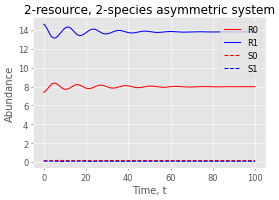

In [103]:
plt.plot(t, sol[:,0], 'r', label = 'R0');
plt.plot(t, sol[:,1],'b', label = 'R1');
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();

plt.title('2-resource, 2-species asymmetric system')
plt.xlabel('Time, t');
plt.ylabel('Abundance');

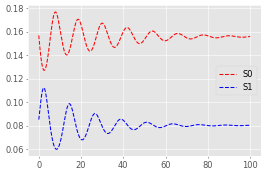

In [104]:
# giving the little guys a chance
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();


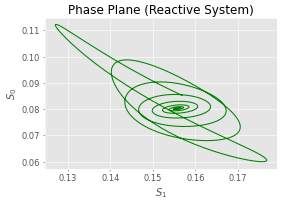

In [105]:
plt.plot(sol[:,2], sol[:,3], 'g');
plt.title('Phase Plane (Reactive System)');
plt.xlabel(r'$S_1$');
plt.ylabel(r'$S_0$');

In [106]:
### NEXT STEPS FOR ARNOLDI TOOLS:
    ### Pick a threshold for the oscillations such that settles in ...

In [107]:
RS_arn
sol

array([[ 7.9836072],
       [13.8027271],
       [ 0.1558248],
       [ 0.0802624]])

array([[ 7.400279 , 14.6149478,  0.1568854,  0.0852164],
       [ 7.4104398, 14.6003087,  0.1546331,  0.086949 ],
       [ 7.4222681, 14.5832852,  0.1524552,  0.0886817],
       ...,
       [ 7.989081 , 13.8049451,  0.1558973,  0.0804053],
       [ 7.9889625, 13.8047394,  0.1559184,  0.0804095],
       [ 7.9888313, 13.8045308,  0.155939 ,  0.0804134]])

In [108]:
RS_arn

array([[ 7.9836072],
       [13.8027271],
       [ 0.1558248],
       [ 0.0802624]])

In [109]:
sol_xs = np.tile(RS_arn.reshape(4), (len(t), 1)) - sol # running difference between each state variable and its respective equilibrium
sol_xs

array([[ 5.8332816e-01, -8.1222077e-01, -1.0605657e-03, -4.9539994e-03],
       [ 5.7316741e-01, -7.9758167e-01,  1.1916376e-03, -6.6865728e-03],
       [ 5.6133909e-01, -7.8055816e-01,  3.3695922e-03, -8.4192628e-03],
       ...,
       [-5.4737470e-03, -2.2180885e-03, -7.2524357e-05, -1.4290253e-04],
       [-5.3552766e-03, -2.0123519e-03, -9.3632408e-05, -1.4715483e-04],
       [-5.2240792e-03, -1.8037653e-03, -1.1425627e-04, -1.5099067e-04]])

In [110]:
# plt.plot(t, sol[:,0], 'r', sol[:,1],'b', sol[:,2],'r--', sol[:,3],'b--');

# General Lotka-Volterra [CAN ALSO SKIP]

In [111]:
# The O'Dwyer model may not be a very "neutral" choice in terms of the equilibrium
    # vectors that it produces. This might make misleading/very particular plots
    # against stability measures?
    

In [112]:
def lv_gen(k, n, sig_mu, sig_alpha):
    ''' Symmetric system
    k, number of matrices
    n, number of species
    sig_mu, standard deviation of intrinsic birth/death rates
    sig_A, standard deviation of interaction rates
    '''
    
    A =  np.random.normal(loc=0, scale=sig_alpha, size=(k,n,n)) # 0 in the diagonal
    A = np.triu(A) - np.transpose(np.triu(A), axes=(0,2,1)) + np.tile(np.eye(n), (k,1,1))
    return A

In [113]:
A = lv_gen(100, 3, 1,1)

In [114]:
# A

In [115]:
# def lv_Jacobian(r, A, x):
#     J = 

# Diversity Measures
$$ ^q \lambda = \sum^{S}_{i=1} p_i^q$$
For $q=1$, all species weighted equally, "without favoring either common or rare species."

All diversity indices
of a given order $q$ have the same true diversity $^qD$

In [263]:
### Parameter/System Reminder
    ### SAME as from section "Arnoldi Measures"

np.random.seed(667)
n = 2
k = 1000
mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)
eps = 0.25
C = np.identity(n)
P = symPvec(sig = 1, n = n, k = k)
# P = asymPvec(sig = 1, n = n, k = k) # FOR n>5, no (empirical?) guarantee of stability
J = community_matr_gen(C,P,eps,mu,rho)
J.shape

R_star = R_star_gen(C,P,eps,mu)
S_star = S_star_gen(C,P,R_star,rho)

(1000, 4, 4)

In [264]:
## Stability measures are already computed by this point
# NOTE: Stability measures computed from O'Dwyer systems are stored as:
# R_0_mb
# I_S_mb
# I_D_mb
# R_inf_mb

# Now, will have _mb## suffix to denote the size of the system (EX: _mb10 for n=10)

## Jost    
All diversity index functions below will take equilibrium vector $N$ and return raw index, not the numbers equivalent.

$H_A$, $H_B$ are any orthogonal quantities/qualities of a diversity index H (EX: alpha and beta diversity, evenness and richness).

In [265]:
def normalize(N):
    '''
    Makes column vector(s) length 1.
    '''
    if N.ndim == 2:
        N = N.reshape(1,N.shape[0],N.shape[1])
    norms = np.sqrt(np.sum(np.square(N),1)).reshape(N.shape[0],1,1)
    N = N/norms
    
    return N

In [266]:
def sum_to_one(N):
    if N.ndim == 2:
        N = N.reshape(1,N.shape[0],N.shape[1])
        
    return N/np.sum(N,1).reshape(N.shape[0],1,1)

In [267]:
s_star = sum_to_one(S_star)
r_star = sum_to_one(R_star)

### Simpson concentration
$$H \equiv \sum^{S}_{i=1} p_i^2$$
$$D = \frac{1}{H}$$
$$ H_A \times H_B = H_{tot}$$

In [268]:
def simpson_conc(N):
    H = np.sum(np.square(N),1)
    # D = 1/H
    
    return H

In [269]:
simpson_s = simpson_conc(s_star)
simpson_r = simpson_conc(r_star)

### Shannon Entropy
$$H \equiv -\sum^{S}_{i=1} p_i \ln(p_i)$$
$$ D = e^{H}$$
H:
$$ H_A + H_B = H_{tot}$$
D (exponential of Shannon entropy):
$$ H_A \times H_B = H_{tot}$$

In [270]:
def shannon_entropy(N): 
    H = -np.sum(N*np.log(N), 1)
    # D = np.exp(H).reshape(N.shape[0],1,1)
    return H

In [271]:
shannon_s = shannon_entropy(s_star)

shannon_r = shannon_entropy(r_star)
shannon_sr = np.concatenate((shannon_s,shannon_r))

### Gini-Simpson index
$$H \equiv 1 - \sum^{S}_{i=1} p_i^2$$
$$ D = 1/(1-H) $$
$$ H_A + H_B - (H_A \times H_B) = H_{tot}$$

In [272]:
def gini_simpson_index(N):
    H = 1 - np.sum(np.square(N), axis = 1)
    # D = 1/(1-H)
    
    return H

In [273]:
gini_simp_s = gini_simpson_index(s_star)
gini_simp_r = gini_simpson_index(r_star)
gini_simp_sr = np.concatenate((gini_simp_s,gini_simp_r))

In [274]:
# Get numbers equivalents from Gini-Simpson
D_s = 1/(1-gini_simp_s)
D_r = 1/(1-gini_simp_r)
D_sr = np.concatenate((D_s,D_r))

In [275]:
np.mean(simpson_s)
np.mean(shannon_s)
np.mean(gini_simp_s)
np.mean(D_s)

0.5061642173101898

0.6869369197545867

0.4938357826898102

1.976340939492245

### HCDT entropy
$$ H \equiv \frac{1 - \sum^{S}_{i=1} p_i^q}{q-1} $$
$$ D = [(1-(q-1)H)]^{1/(1-q)} $$
$$ H_A + H_B - (q-1)(H_A)(H_B) = H_{tot}$$

### Renyi entropy
$$ H \equiv \frac{-\ln\sum^{S}_{i=1} p_i^q}{q-1} $$
$$ D = e^H $$
$$ H_A + H_B = H_{tot}$$

### Universal

$$ ^q D_{tot} = ^q D_A \times ^qD_B$$
$$ D(H_{\gamma}) = D(H_{\alpha})D(H_{\beta}) $$ (Whittaker's law) 

$$^qD_{\alpha} \equiv D(^q\lambda_{\alpha})$$ 
$$ =  \left[ \frac{\sum^C_{j=1}[w^q_j \sum^S_{i=1} (p^q_{ij})]}{\sum^C_{j=1}(w^q_j)} \right]^{1/(1-q)} $$

where S is number of species, C is number of communities, $w_j$ is statistical weight of community $j$, and q is partiality to rare or common species.

Above undefined for q=1. Limit:
$$^1 D_{\alpha} = exp\left[ \sum^C_{j=1}[-w_j \sum^S_{i=1}(p_{ij}\ln p_{ij})] \right]$$

Alpha:
$$ ^qD_{\alpha} = ^q \lambda^{1/(1-q)}_{\alpha}$$
Gamma:
$$ ^qD_{\gamma} = ^q \lambda^{1/(1-q)}_{\gamma}$$

In [276]:
# Universal numbers equivalent
def numbers_equiv_alpha(w,p,q):
    '''
    There are C communities and S species.
    
    Takes community weights w (vector of length C), species probabilities p of size (S,C), and order q of the diversity index.
    Returns numbers equivalent of diversity index's alpha component.
    '''
    w = w.reshape(p.shape[0],1)
    
    if (q==1): # undefined case, need formula that takes the limit as q->1
        D_alpha = np.exp(np.sum(-w * np.sum(p*np.log(p),1) ))

    else:
        num = np.sum(np.power(w,q)*np.sum(np.power(p,q),1) ) # take the species sums of p with axis=0
        den = np.sum(np.power(w,q))
        
        D_alpha = np.power(num/den, 1/(1-q))
        
    return D_alpha

In [277]:
def numbers_equiv_gamma(w,p,q):
    w = w.reshape(p.shape[0],1,1)
    
    weight_sum = np.sum(w*p)
    
    if (q==1):
        D_gamma = np.exp(np.sum(-weight_sum*np.log(weight_sum)))
        
    else:
        # Really, Jost only explicitly gives formula for even weights. Should work like this, right?
        D_gamma = np.power(np.sum(w*p), q)
        D_gamma = np.power(D_gamma, 1/(1-q))
        
    return D_gamma 

In [278]:
k
n = 2

1000

In [279]:
w = np.ones(k)/k # assume k equally weighted communities? Like from k different communities
D1_alpha = numbers_equiv_alpha(w, s_star, 1)

D1_gamma = numbers_equiv_gamma(w, s_star, 1)
print('alpha: ', D1_alpha)
print('gamma: ', D1_gamma)
D1_beta = D1_gamma/D1_alpha
print('beta: ', D1_beta)

alpha:  1.9876179660146078
gamma:  1.0
beta:  0.5031147922279601


In [280]:
numbers_equiv_alpha(w,s_star,1)

1.9876179660146078

In [281]:
numbers_equiv_alpha(w,s_star,2)

1.975643409394102

In [282]:
numbers_equiv_alpha(w,s_star,-1)

2.012867374755755

#  Stability vs. Diversity

## 2-Species system

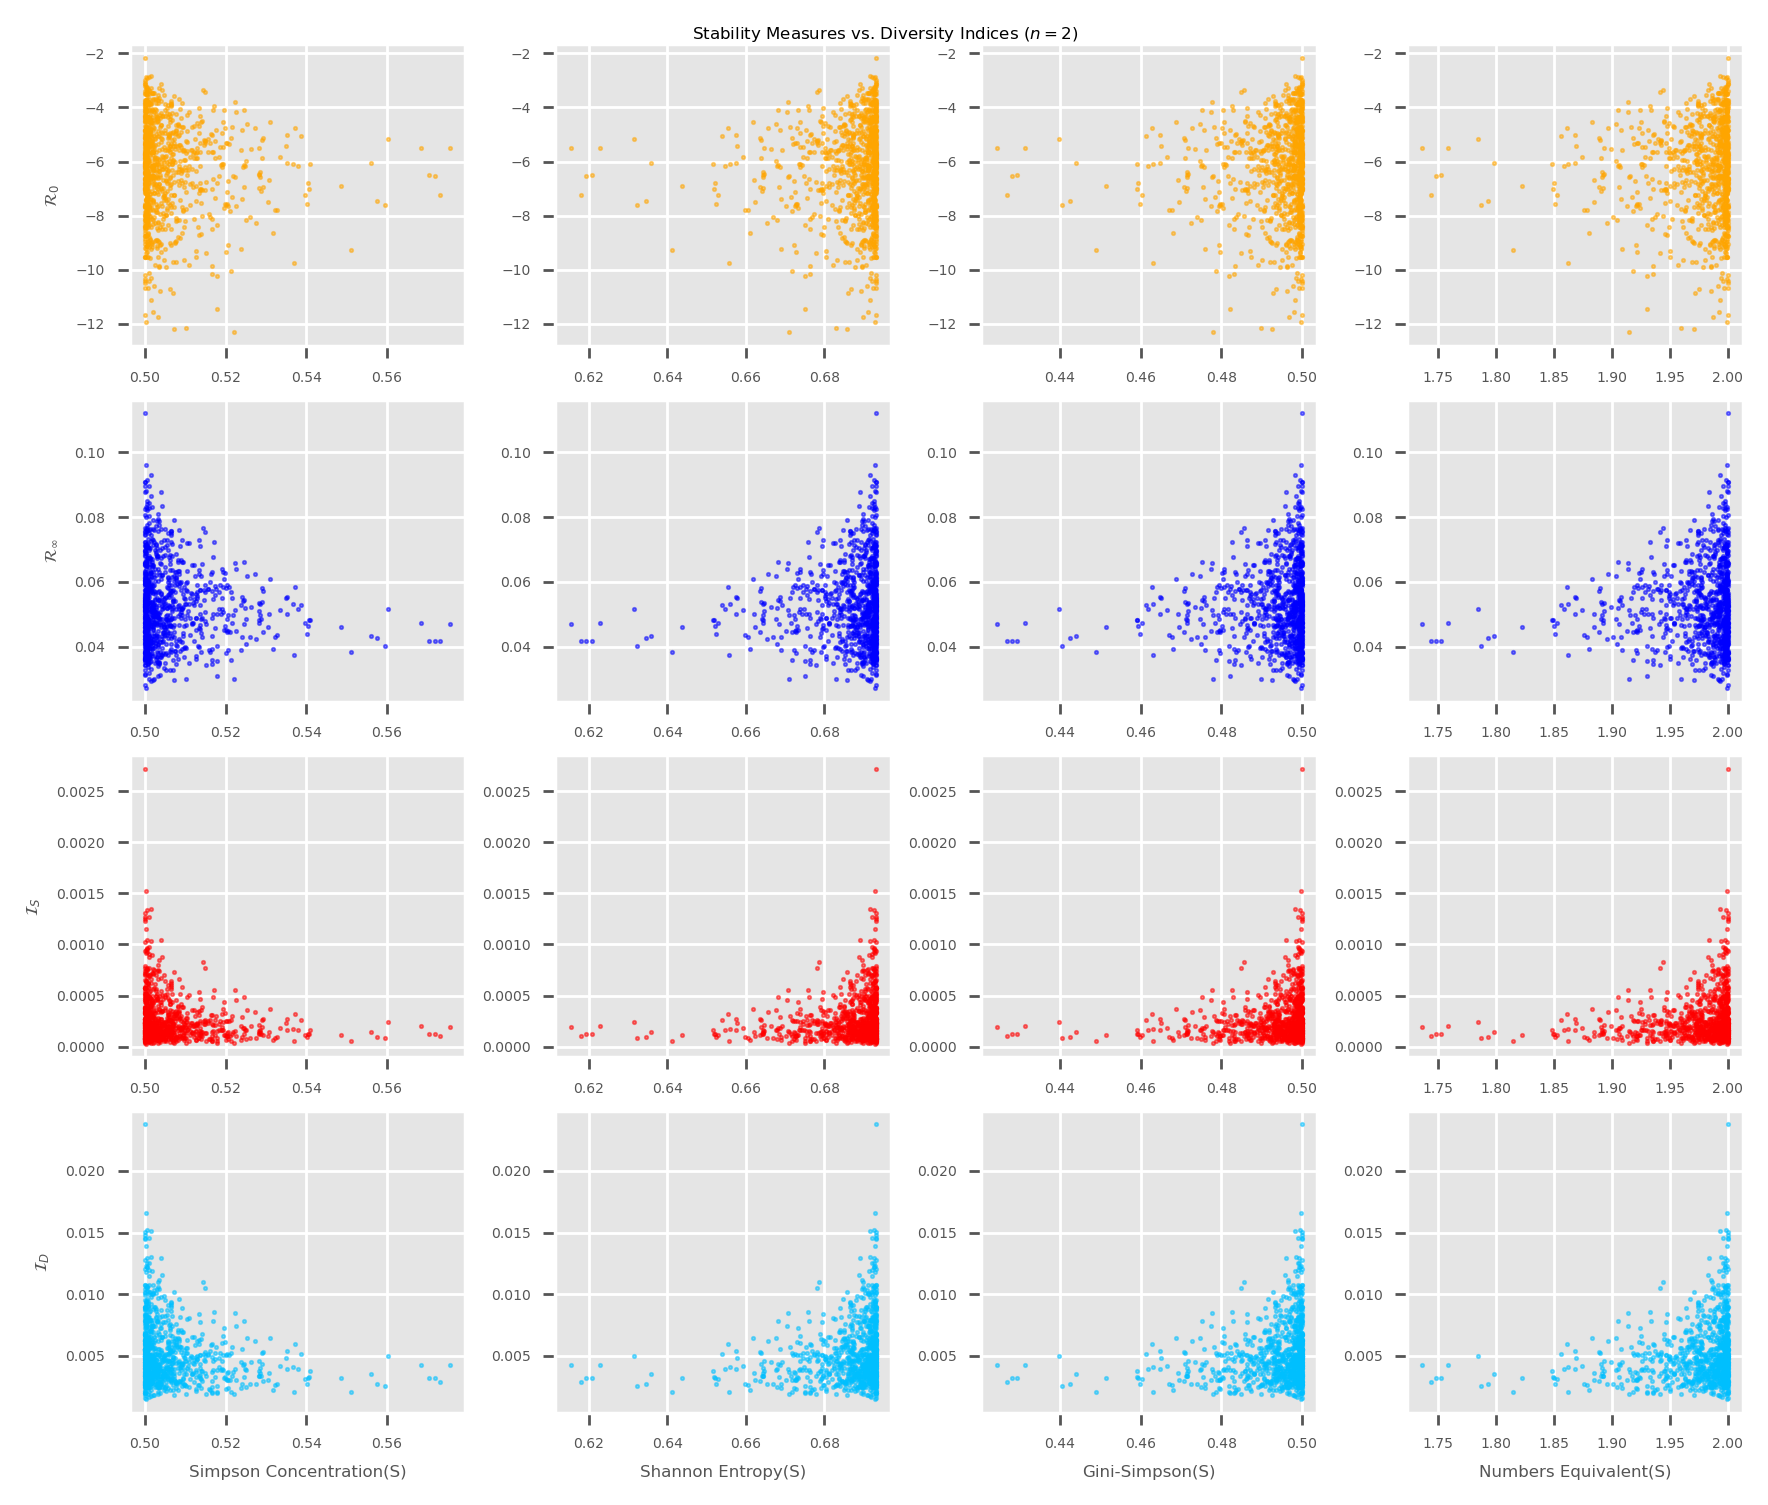

In [283]:
# O'Dwyer n=2 Plots
plt.figure(figsize=(7,6),dpi=250)
mpl.rcParams.update({'font.size': 4})
plt.suptitle('Stability Measures vs. Diversity Indices ($n=2$)');

### Initial Resilience (Row 1) ###
plt.subplot(4,4,1);
plt.scatter(simpson_s, R_0_mb, s = 1, alpha=0.5, color = 'orange');
plt.ylabel(r'$\mathcal{R}_{0}$');

plt.subplot(4,4,2);
plt.scatter(shannon_s, R_0_mb, s = 1, alpha=0.5, c = 'orange');

plt.subplot(4,4,3);
plt.scatter(gini_simp_s, R_0_mb, s = 1, alpha=0.5, c = 'orange');

plt.subplot(4,4,4);
plt.scatter(D_s, R_0_mb, s = 1, alpha=0.5, color = 'orange');

### Asymptotic Resilience (Row 2) ###
plt.subplot(4,4,5);
plt.scatter(simpson_s, R_inf_mb, s = 1, alpha=0.5, color = 'blue');
plt.ylabel(r'$\mathcal{R}_{\infty}$');

plt.subplot(4,4,6);
plt.scatter(shannon_s, R_inf_mb, s = 1, alpha=0.5, color = 'blue');

plt.subplot(4,4,7);
plt.scatter(gini_simp_s, R_inf_mb, s = 1, alpha=0.5, color = 'blue');

plt.subplot(4,4,8);
plt.scatter(D_s, R_inf_mb, s = 1, alpha=0.5, color = 'blue');

### Stochastic Invariability (Row 3) ###
plt.subplot(4,4,9);
plt.scatter(simpson_s, I_S_mb, s = 1, alpha=0.5, color = 'red');
plt.ylabel(r'$\mathcal{I}_S$');

plt.subplot(4,4,10);
plt.scatter(shannon_s, I_S_mb, s = 1, alpha=0.5, color = 'red');

plt.subplot(4,4,11);
plt.scatter(gini_simp_s, I_S_mb, s = 1, alpha=0.5, color = 'red');

plt.subplot(4,4,12);
plt.scatter(D_s, I_S_mb, s = 1, alpha=0.5, color = 'red');

### Deterministic Invariability (Row 4) ###
plt.subplot(4,4,13);
plt.scatter(simpson_s, I_D_mb, s = 1, alpha=0.5, color = 'deepskyblue');
plt.ylabel(r'$\mathcal{I}_D$');
plt.xlabel('Simpson Concentration(S)');

plt.subplot(4,4,14);
plt.scatter(shannon_s, I_D_mb, s = 1, alpha=0.5, color = 'deepskyblue');
plt.xlabel('Shannon Entropy(S)');

plt.subplot(4,4,15);
plt.scatter(gini_simp_s, I_D_mb, s = 1, alpha=0.5, color = 'deepskyblue');
plt.xlabel('Gini-Simpson(S)');

plt.subplot(4,4,16);
plt.scatter(D_s, I_D_mb, s = 1, alpha=0.5, color = 'deepskyblue');
plt.xlabel('Numbers Equivalent(S)');

plt.tight_layout();

In [137]:
# Numbers equivalents column shows tendency toward (a mode of) ~2.0 effective species, 
    # a result of many species vectors being split about 50/50 at equilbrium.
# We know that the Numbers Equivalents never dip below 1 for an n=2 system.

In [138]:
s_star[np.argmin(D_s)] # The equilbrium responsible for the left-most point on most of the above plots.

array([[0.1724168],
       [0.8275832]])

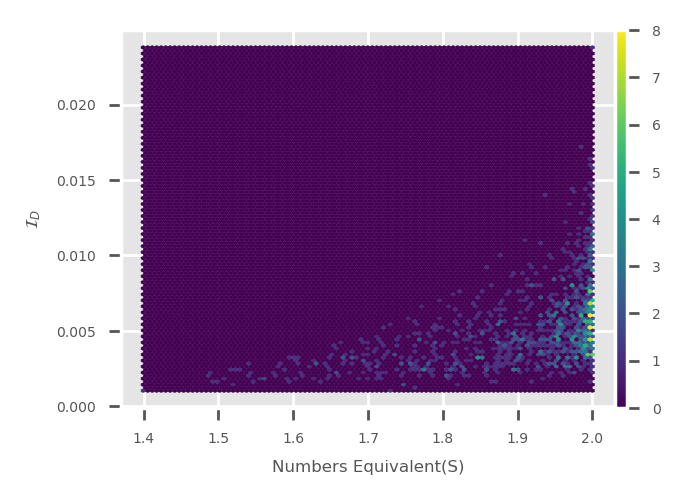

In [139]:
# Might make more sense to use heatmaps when scatters have many points?
plt.figure(figsize=(3,2),dpi=250)
mpl.rcParams.update({'font.size': 4})
plt.hexbin(D_s.reshape(-1), I_D_mb.reshape(-1), linewidths=0.1);
plt.colorbar(aspect=30, shrink=1, pad=0.00)
plt.xlabel('Numbers Equivalent(S)');
plt.ylabel(r'$\mathcal{I}_D$');

## 10-Species system

In [477]:
np.random.seed(667)
n = 10
k = 1000
mu = (np.ones(n)*1).reshape(n,1) #* 0.5
rho = (np.ones(n)*1).reshape(n,1) #* 0.5
eps = 0.25
C = np.identity(n)
P = symPvec(sig = 1, n = n, k = k) 
# P = asymPvec(sig = 1, n = n, k = k) # FOR n>5, no (empirical?) guarantee of stability
J10 = community_matr_gen(C,P,eps,mu,rho)
J10.shape

R_star10 = R_star_gen(C,P,eps,mu)
S_star10 = S_star_gen(C,P,R_star10,rho)

(1000, 20, 20)

In [478]:
# Get the new diversity indices for this bigger system
s_star10 = sum_to_one(S_star10)
r_star10 = sum_to_one(R_star10)

simpson_s10 = simpson_conc(s_star10)
shannon_s10 = shannon_entropy(s_star10)
gini_simp_s10 = gini_simpson_index(s_star10)
D_s10 = 1/(1-gini_simp_s10)

In [479]:
# Get new stability measures for this bigger system
R_0_mb10 = init_res(J10)
R_inf_mb10 = asym_res(J10)

In [480]:
I_S_mb10 = np.zeros(k)
for i in range(k):
    I_S_mb10[i] = stoch_invar(J10[i,:,:])

I_S_mb10.shape

(1000,)

In [482]:
I_D_mb10 = np.zeros(k)
oms10 = np.zeros(k)
for i in range(k):
    
    out = minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(J10[i,:,:]), method='brent')

    oms10[i] = out.x
    I_D_mb10[i] = -1/out.fun # out.fun is still negative bc of obj function minimizing the opposite to find maximum

I_D_mb10.shape

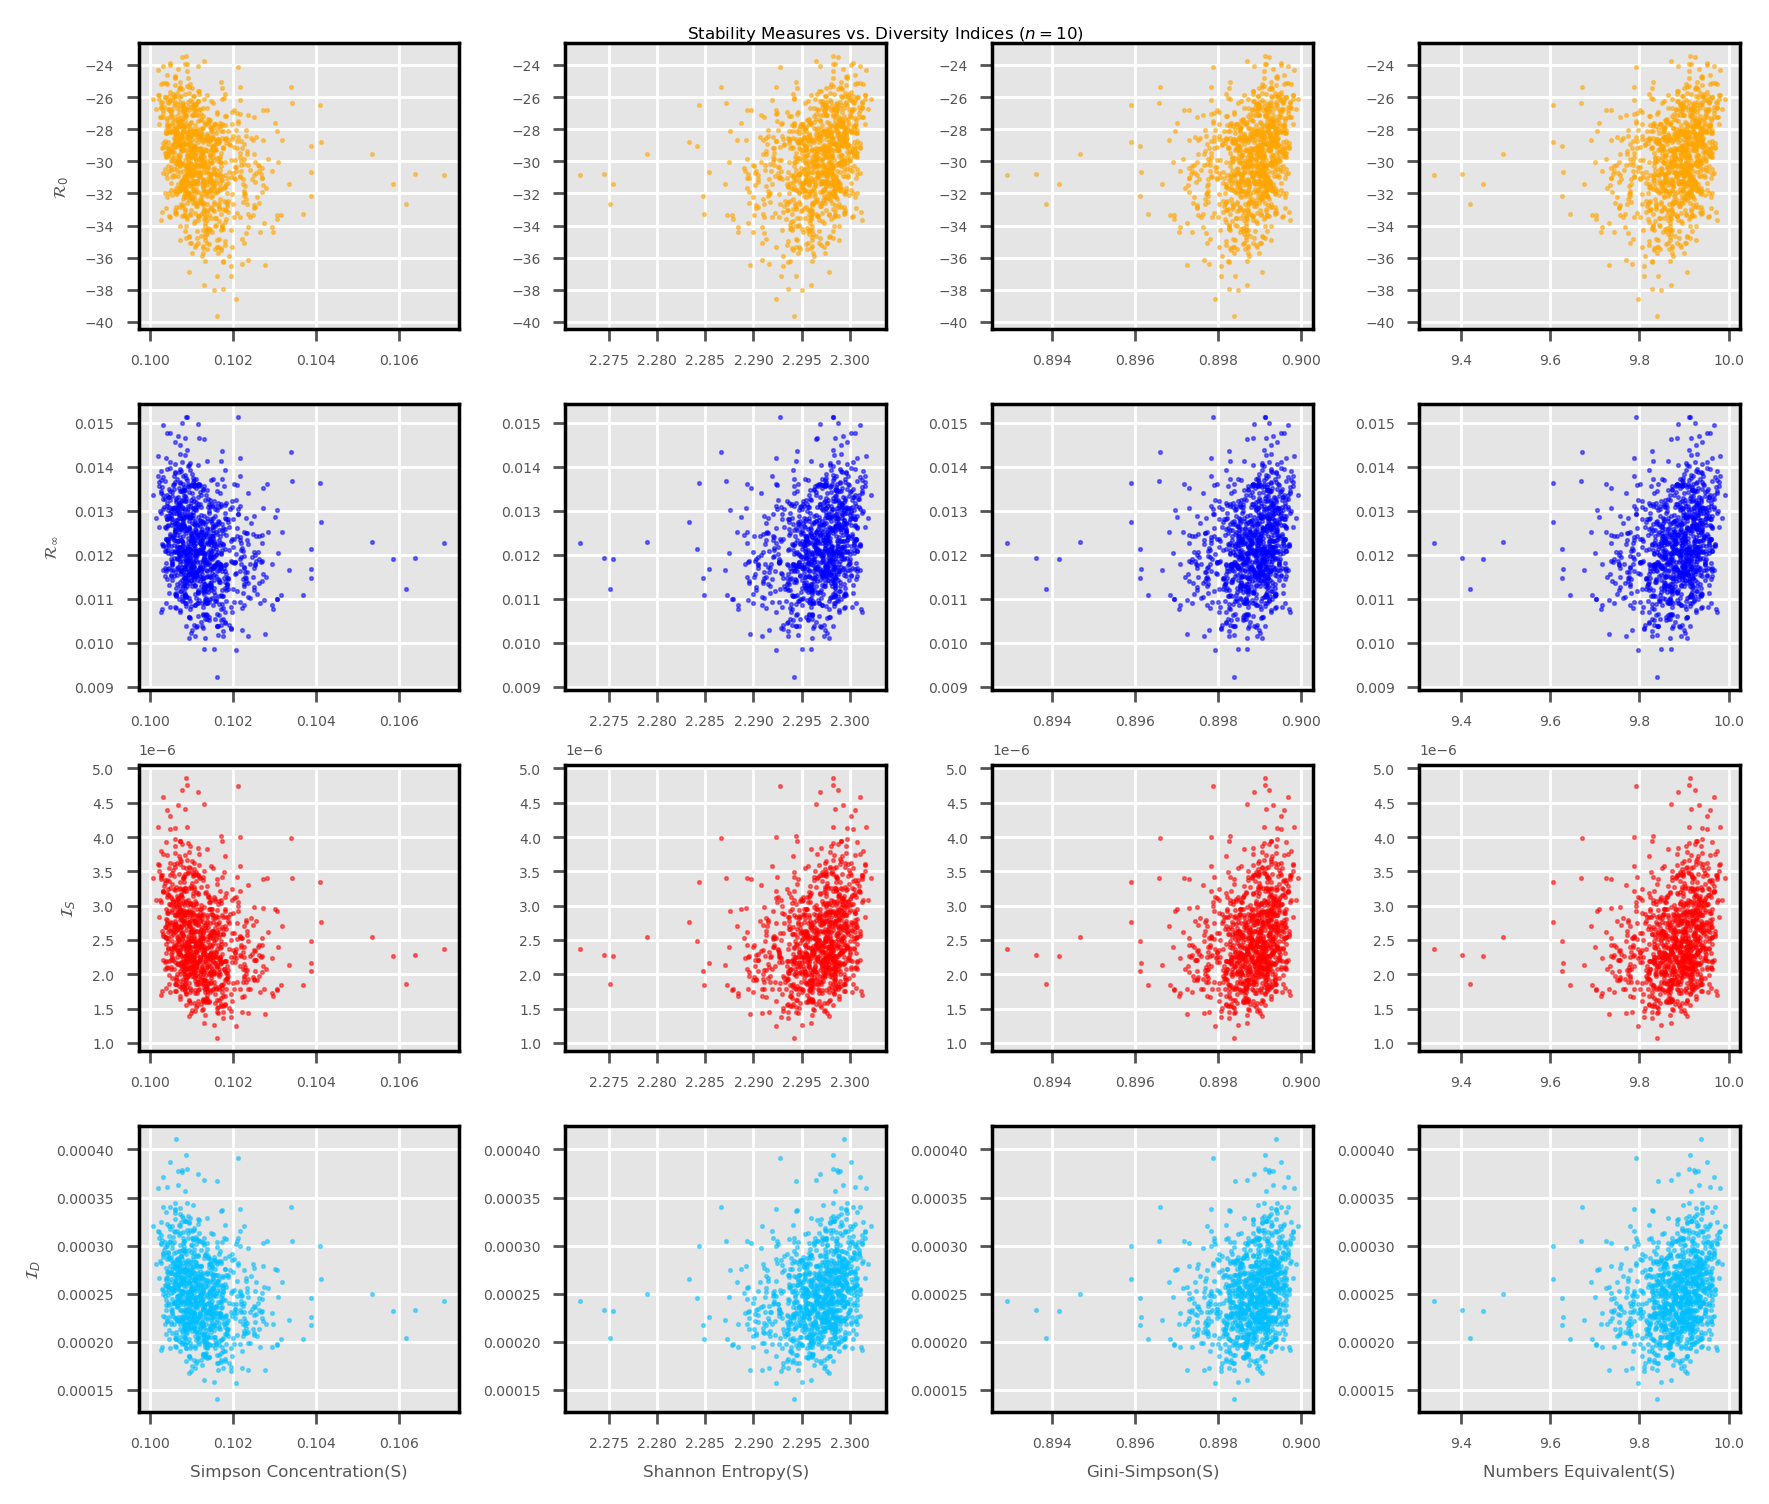

In [483]:
# O'Dwyer n=10 Plots
plt.figure(figsize=(7,6),dpi=250)
mpl.rcParams.update({'font.size': 4})
plt.suptitle('Stability Measures vs. Diversity Indices ($n=10$)');

### Initial Resilience (Row 1) ###
plt.subplot(4,4,1);
plt.scatter(simpson_s10, R_0_mb10, s = 1, alpha=0.5, color = 'orange');
plt.ylabel(r'$\mathcal{R}_{0}$');

plt.subplot(4,4,2);
plt.scatter(shannon_s10, R_0_mb10, s = 1, alpha=0.5, c = 'orange');

plt.subplot(4,4,3);
plt.scatter(gini_simp_s10, R_0_mb10, s = 1, alpha=0.5, c = 'orange');

plt.subplot(4,4,4);
plt.scatter(D_s10, R_0_mb10, s = 1, alpha=0.5, color = 'orange');

### Asymptotic Resilience (Row 2) ###
plt.subplot(4,4,5);
plt.scatter(simpson_s10, R_inf_mb10, s = 1, alpha=0.5, color = 'blue');
plt.ylabel(r'$\mathcal{R}_{\infty}$');

plt.subplot(4,4,6);
plt.scatter(shannon_s10, R_inf_mb10, s = 1, alpha=0.5, color = 'blue');

plt.subplot(4,4,7);
plt.scatter(gini_simp_s10, R_inf_mb10, s = 1, alpha=0.5, color = 'blue');

plt.subplot(4,4,8);
plt.scatter(D_s10, R_inf_mb10, s = 1, alpha=0.5, color = 'blue');

### Stochastic Invariability (Row 3) ###
plt.subplot(4,4,9);
plt.scatter(simpson_s10, I_S_mb10, s = 1, alpha=0.5, color = 'red');
plt.ylabel(r'$\mathcal{I}_S$');

plt.subplot(4,4,10);
plt.scatter(shannon_s10, I_S_mb10, s = 1, alpha=0.5, color = 'red');

plt.subplot(4,4,11);
plt.scatter(gini_simp_s10, I_S_mb10, s = 1, alpha=0.5, color = 'red');

plt.subplot(4,4,12);
plt.scatter(D_s10, I_S_mb10, s = 1, alpha=0.5, color = 'red');

### Deterministic Invariability (Row 4) ###
plt.subplot(4,4,13);
plt.scatter(simpson_s10, I_D_mb10, s = 1, alpha=0.5, color = 'deepskyblue');
plt.ylabel(r'$\mathcal{I}_D$');
plt.xlabel('Simpson Concentration(S)');

plt.subplot(4,4,14);
plt.scatter(shannon_s10, I_D_mb10, s = 1, alpha=0.5, color = 'deepskyblue');
plt.xlabel('Shannon Entropy(S)');

plt.subplot(4,4,15);
plt.scatter(gini_simp_s10, I_D_mb10, s = 1, alpha=0.5, color = 'deepskyblue');
plt.xlabel('Gini-Simpson(S)');

plt.subplot(4,4,16);
plt.scatter(D_s10, I_D_mb10, s = 1, alpha=0.5, color = 'deepskyblue');
plt.xlabel('Numbers Equivalent(S)');

plt.tight_layout();

## n-Species system

In [509]:
class ODsystem:
    '''
    Class to make O'Dwyer systems + their community matrices and equilibria + Arnoldi Measures.
    VERY slow when n>~6, a problem from being a class and for-looping I_S and I_D
    -------------------------------------------------------
    Specify:
    k, number of systems
    n, number of species and number of resources
    mu, vector of mortality rates
    rho, vector of resource influx rates
    eps, resource consumers' conversion efficiency of biomass
    sig_P, standard deviation of entries in production matrix P
    C, consumption matrix
    '''
    def __init__(self, k_=1000,n_=5, mu_=None, rho_=None, eps_=0.25, sig_P_=1, C_ = None):
        self.k = k_
        self.n = n_
        self.sig_P = sig_P_
        
        if mu_ is None:
            self.mu = np.ones(self.n).reshape(self.n,1)
        else:
            self.mu = mu_
            
        if rho_ is None:
            self.rho = np.ones(self.n).reshape(self.n,1)
        else:
            self.rho = rho_
            
        if C_ is None:
            self.C = np.identity(self.n)
        else:
            self.C = C_
            
        self.eps = eps_
        self.P = asymPvec(sig = self.sig_P, n = self.n, k = self.k)
        # self.P = symPvec(sig = self.sig_P, n = self.n, k = self.k)

        self.J = community_matr_gen(self.C,self.P,self.eps,self.mu,self.rho)

        self.R_star = R_star_gen(self.C,self.P,self.eps,self.mu)
        self.S_star = S_star_gen(self.C,self.P,self.R_star,self.rho)
        
        ### Arnoldi Measures ###
        self.R_0 = init_res(self.J)
        self.R_inf = asym_res(self.J)
        self.I_S = np.zeros(self.k)
        for i in range(self.k):
            self.I_S[i] = stoch_invar(self.J[i,:,:])
        self.I_D = np.zeros(self.k)
        for i in range(self.k):
            self.I_D[i] = -1/minimize_scalar(determ_invar_OBJ, bracket = (0,3), args=(self.J[i,:,:]), method='brent').fun

        ### Diversity Measures ###
        self.s_star = sum_to_one(self.S_star)
        self.r_star = sum_to_one(self.R_star)

        self.simpson_s = simpson_conc(self.s_star)
        self.shannon_s = shannon_entropy(self.s_star)
        self.gini_simp_s = gini_simpson_index(self.s_star)
        self.D_s = 1/(1-self.gini_simp_s)
        
    def stab_div_plot(self, fsize=(7,6), res = 250, fontsize=4):
        plt.figure(figsize=(7,6), dpi=250)
        plt.style.use('ggplot')
        mpl.rcParams.update({'font.size': 4})
        plt.suptitle('Stability Measures vs. Diversity Indices ($n=${})'.format(self.n));

        ### Initial Resilience (Row 1) ###
        plt.subplot(4,4,1);
        plt.scatter(self.simpson_s, self.R_0, s = 1, alpha=0.5, color = 'orange');
        plt.ylabel(r'$\mathcal{R}_{0}$');

        plt.subplot(4,4,2);
        plt.scatter(self.shannon_s, self.R_0, s = 1, alpha=0.5, c = 'orange');

        plt.subplot(4,4,3);
        plt.scatter(self.gini_simp_s, self.R_0, s = 1, alpha=0.5, c = 'orange');

        plt.subplot(4,4,4);
        plt.scatter(self.D_s, self.R_0, s = 1, alpha=0.5, color = 'orange');

        ### Asymptotic Resilience (Row 2) ###
        plt.subplot(4,4,5);
        plt.scatter(self.simpson_s, self.R_inf, s = 1, alpha=0.5, color = 'blue');
        plt.ylabel(r'$\mathcal{R}_{\infty}$');

        plt.subplot(4,4,6);
        plt.scatter(self.shannon_s, self.R_inf, s = 1, alpha=0.5, color = 'blue');

        plt.subplot(4,4,7);
        plt.scatter(self.gini_simp_s, self.R_inf, s = 1, alpha=0.5, color = 'blue');

        plt.subplot(4,4,8);
        plt.scatter(self.D_s, self.R_inf, s = 1, alpha=0.5, color = 'blue');

        ### Stochastic Invariability (Row 3) ###
        plt.subplot(4,4,9);
        plt.scatter(self.simpson_s, self.I_S, s = 1, alpha=0.5, color = 'red');
        plt.ylabel(r'$\mathcal{I}_S$');

        plt.subplot(4,4,10);
        plt.scatter(self.shannon_s, self.I_S, s = 1, alpha=0.5, color = 'red');

        plt.subplot(4,4,11);
        plt.scatter(self.gini_simp_s, self.I_S, s = 1, alpha=0.5, color = 'red');

        plt.subplot(4,4,12);
        plt.scatter(self.D_s, self.I_S, s = 1, alpha=0.5, color = 'red');

        ### Deterministic Invariability (Row 4) ###
        plt.subplot(4,4,13);
        plt.scatter(self.simpson_s, self.I_D, s = 1, alpha=0.5, color = 'deepskyblue');
        plt.ylabel(r'$\mathcal{I}_D$');
        plt.xlabel('Simpson Concentration(S)');

        plt.subplot(4,4,14);
        plt.scatter(self.shannon_s, self.I_D, s = 1, alpha=0.5, color = 'deepskyblue');
        plt.xlabel('Shannon Entropy(S)');

        plt.subplot(4,4,15);
        plt.scatter(self.gini_simp_s, self.I_D, s = 1, alpha=0.5, color = 'deepskyblue');
        plt.xlabel('Gini-Simpson(S)');

        plt.subplot(4,4,16);
        plt.scatter(self.D_s, self.I_D, s = 1, alpha=0.5, color = 'deepskyblue');
        plt.xlabel('Numbers Equivalent(S)');

        plt.tight_layout();

In [407]:
# To summarize, classes make pretty much every operation slower (e.g., self.x vs. x).

In [513]:
np.random.seed(667)
OD2 = ODsystem(n_=2)

In [512]:
np.random.seed(667)
OD3 = ODsystem(n_=3)

In [514]:
np.random.seed(667)
OD5 = ODsystem(n_=5)

In [515]:
np.random.seed(667)
OD10 = ODsystem(n_=10) # VEERYYY slow. We are in quadratic time. It does finish eventually.

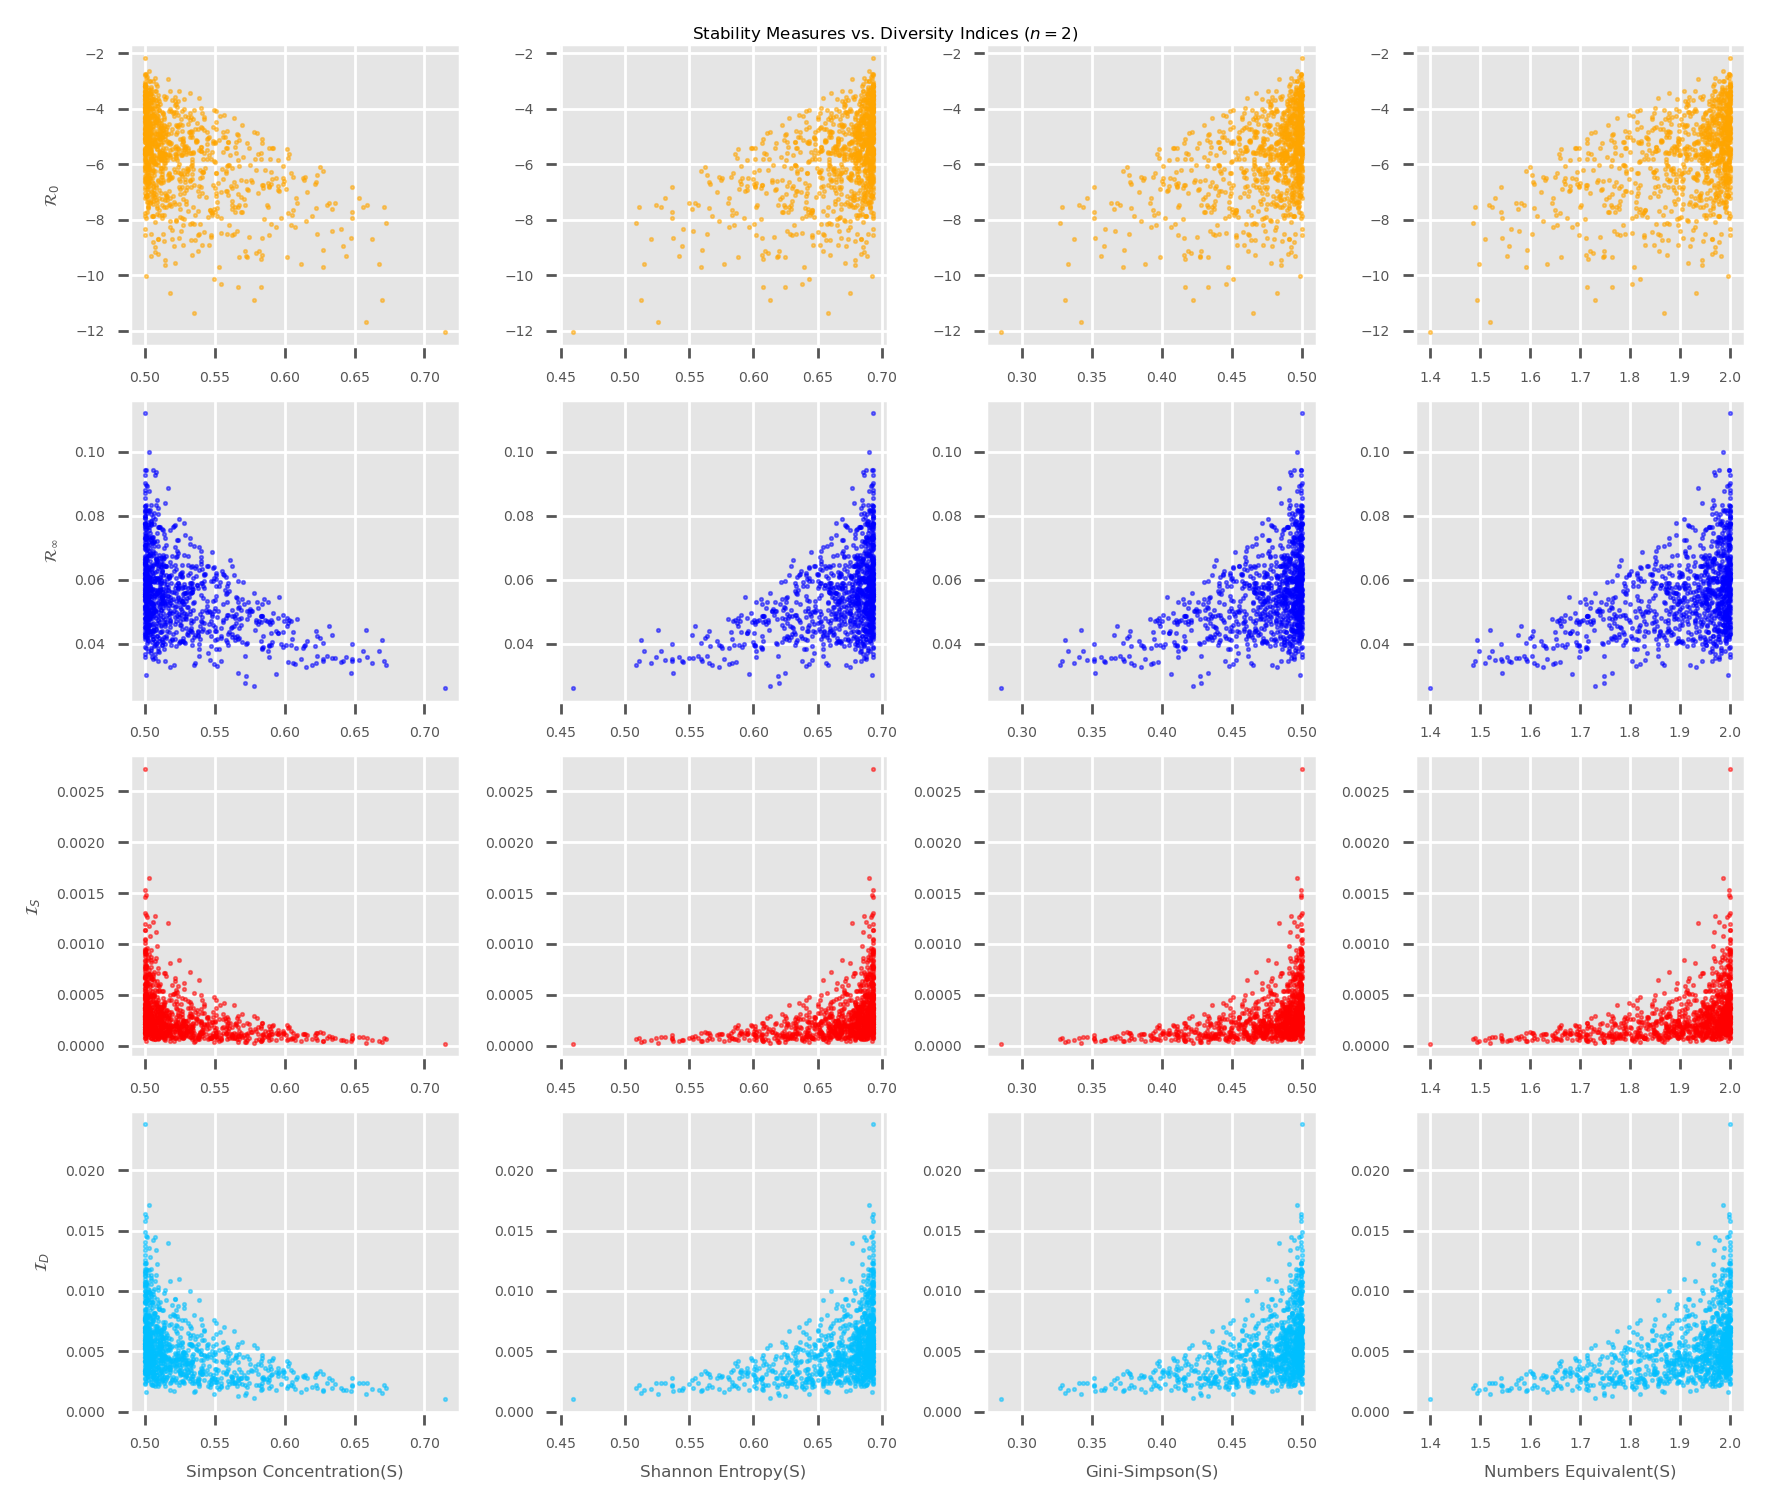

In [516]:
OD2.stab_div_plot()

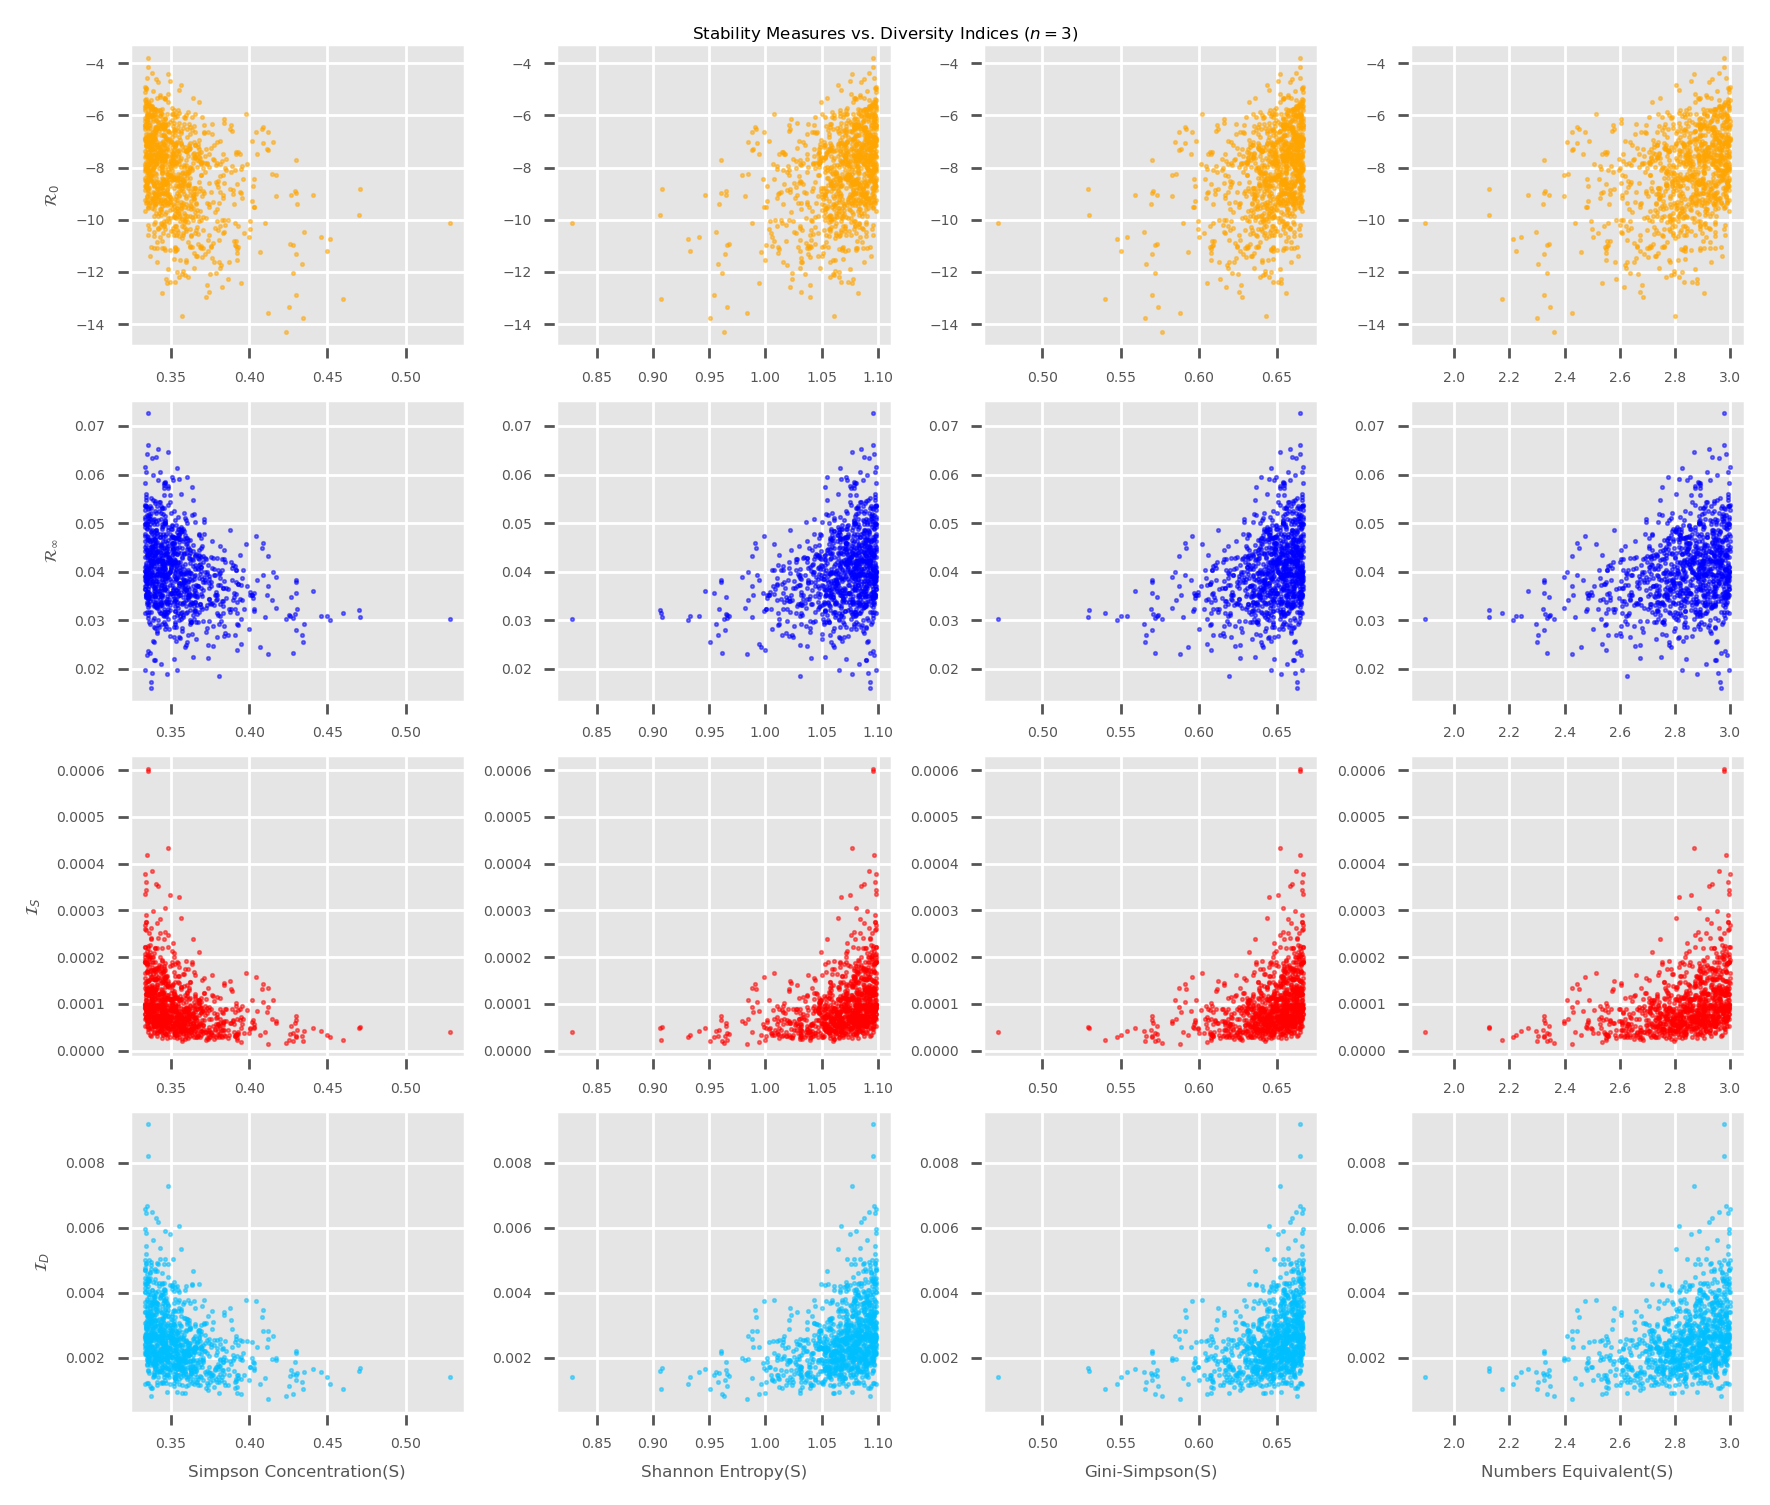

In [511]:
OD3.stab_div_plot()

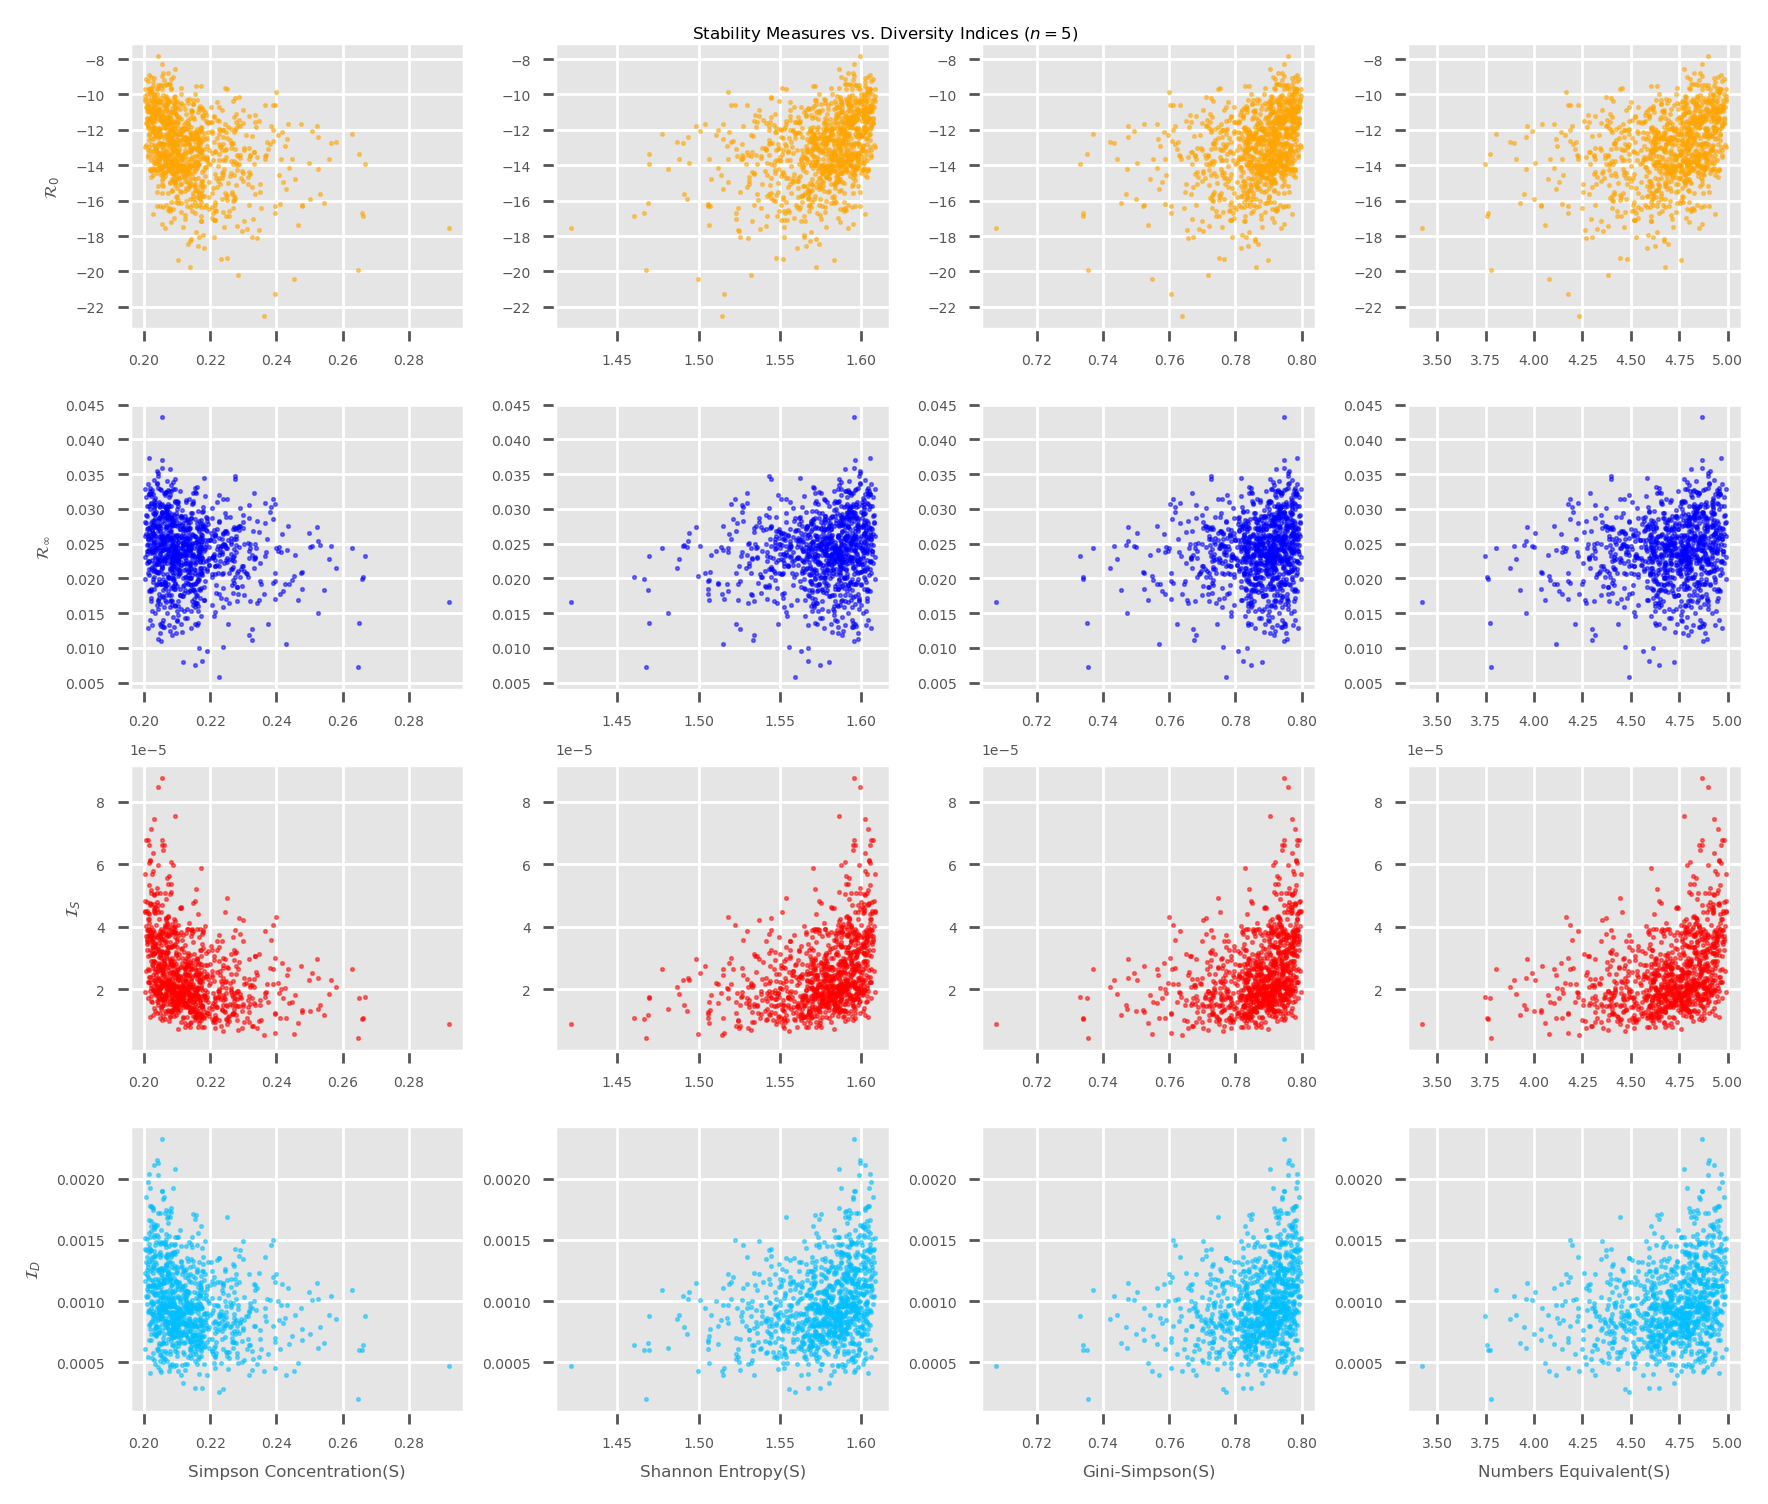

In [517]:
OD5.stab_div_plot()

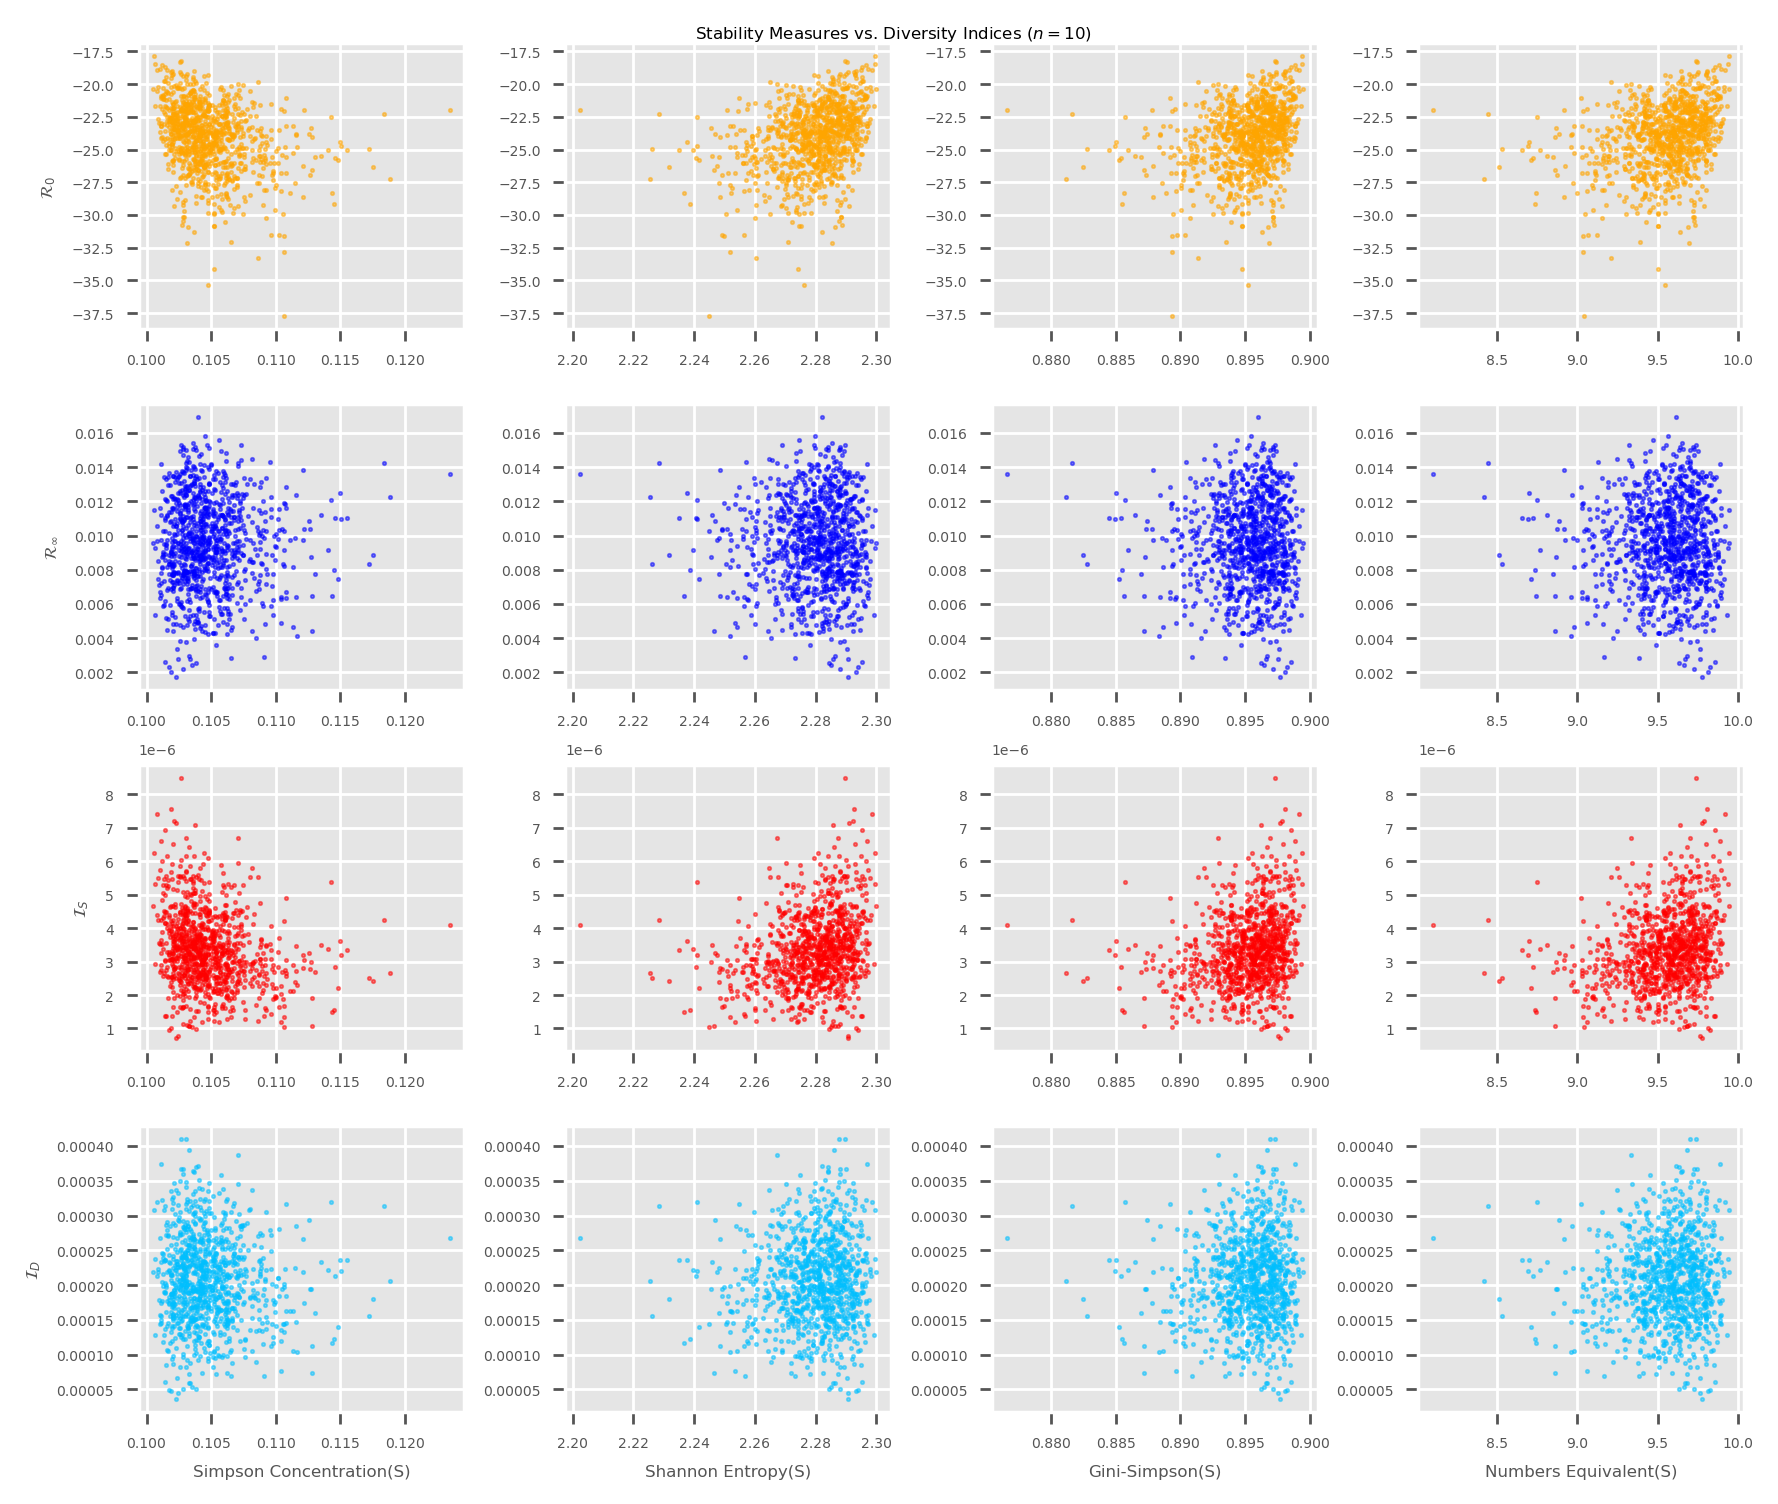

In [518]:
OD10.stab_div_plot()

In [520]:
# Check out some summary stats between the system sizes
np.mean(OD2.R_0)
np.mean(OD3.R_0)
np.mean(OD5.R_0)
np.mean(OD10.R_0)

-5.796385778705029

-8.282679651269271

-13.099696503608977

-24.09894101927089

In [524]:
np.std(OD2.simpson_s)
np.std(OD3.simpson_s)
np.std(OD5.simpson_s)
np.std(OD10.simpson_s)

0.03429836874206007

0.021852273399011468

0.01139321704003964

0.002729231805215019

In [527]:
np.std(OD2.D_s)
np.std(OD3.D_s)
np.std(OD5.D_s)
np.std(OD10.D_s)

0.11160984314971789

0.15584066996577584

0.22974210849061363

0.23893796009866783

In [530]:
np.mean(OD2.n - OD2.D_s) # Mean difference between number of species and effective number of species
np.mean(OD3.n - OD3.D_s) 
np.mean(OD5.n - OD5.D_s) 
np.mean(OD10.n - OD10.D_s)

0.09551598452436777

0.1769046276442158

0.31675189044505153

0.45630548178156155

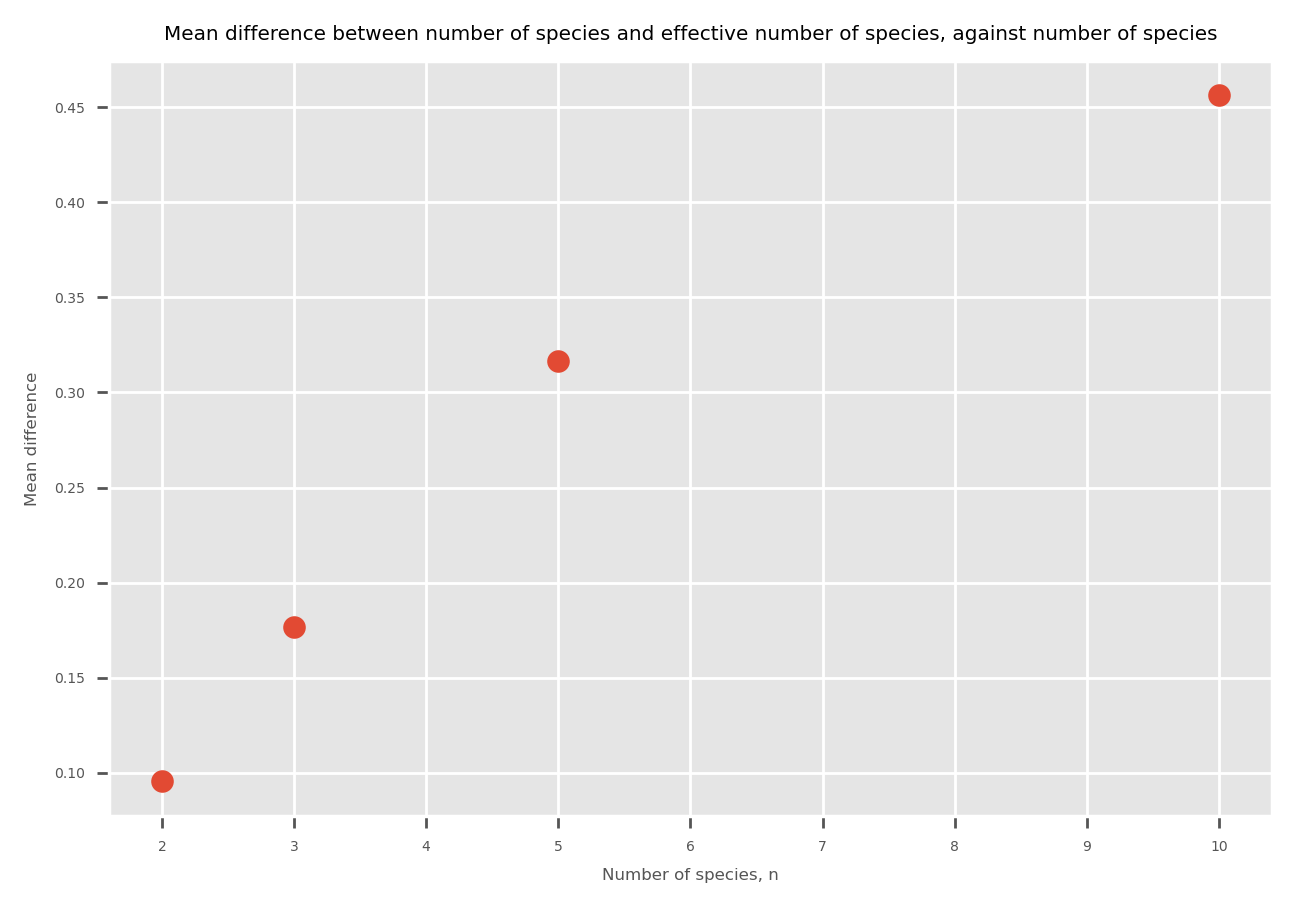

In [537]:
plt.scatter([2,3,5,10],[0.09551598452436777,0.1769046276442158,0.31675189044505153,0.45630548178156155]);
plt.title('Mean difference between number of species and effective number of species, against number of species');
plt.ylabel('Mean difference');
plt.xlabel('Number of species, n');